In [1]:
import pandas as pd
import numpy as np

from mpl_toolkits.axes_grid1.inset_locator import inset_axes # inset
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# qqplot
import statsmodels.api as sm
import pylab as py

from scipy.stats import mannwhitneyu,wilcoxon,spearmanr,ttest_ind
from scipy.stats import sem

In [2]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
# import R's "base" package
lme4 = importr('lme4')
mass = importr('MASS')
rcompanion = importr('rcompanion')

In [3]:
# Set the style to remove top and right borders
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
# set the font size
plt.rcParams.update({'font.size': 11})
# remove legend edge
plt.rcParams['legend.frameon'] = False

In [4]:
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

# add p-value to figure
def text(p):
    if (0.001 < p < 0.01)|(p == 0.001):
        axs.text((x1+x2)*.5, y+h,  r"**", ha='center', va='bottom', color=col, fontsize = 8)
    elif p < 0.001:
        axs.text((x1+x2)*.5, y+h, r"***", ha='center', va='bottom', color=col, fontsize = 8)
    elif (0.01 < p < 0.05)|(p == 0.01):
        axs.text((x1+x2)*.5, y+h, r"*", ha='center', va='bottom', color=col, fontsize = 8)
    else:
        axs.text((x1+x2)*.5, y+h, r"n.s.", ha='center', va='bottom', color=col, fontsize = 8)

# Load data

In [5]:
home_dir = '/Users/dbao/My_Drive'+'/road_construction/data/2022_online/'
data_dir = home_dir + 'R_analysis_data/'
out_dir = home_dir + 'figures/figures_final/'
out_dir2 = home_dir + 'stat_model/final/'

In [66]:
data_choice_level = pd.read_csv(data_dir +  'choice_level/choicelevel_data.csv') # first column is index  
data_choice_level = data_choice_level.rename(columns={'Unnamed: 0':'index_copy'})

# Convert checkEnd to integer
data_choice_level["checkEnd"] = pd.to_numeric(data_choice_level["checkEnd"])
data_choice_level['currNumCities'] = data_choice_level.currNumCities - 1 # starting from 0
data_choice_level['allMAS'] = data_choice_level.allMAS - 1
data_choice_level['currMas'] = data_choice_level.currMas - 1
data_choice_level['N_more'] = data_choice_level["currMas"] - data_choice_level["currNumCities"]

sc_data_choice_level = data_choice_level[data_choice_level['condition']==1].reset_index(drop=True) 

In [7]:
data_puzzle_level = pd.read_csv(data_dir +  'data.csv') # first column is subject
puzzleID_order_data = data_puzzle_level.sort_values(["subjects","puzzleID","condition"])

puzzleID_order_data['mas'] = puzzleID_order_data.mas - 1

# add branching-node RT to puzzle data
index_start = data_choice_level.index[(data_choice_level['branchingFirst'] == True)]
RT_branching = list(data_choice_level.loc[index_start+1, 'RT'])
subjects_chosen = list(data_choice_level.loc[index_start+1, 'subjects'])
puzzle_chosen = list(data_choice_level.loc[index_start+1, 'puzzleID'])

for i in range(len(subjects_chosen)): #
    index_chosen = puzzleID_order_data.index[(puzzleID_order_data['condition']==1)&(puzzleID_order_data['subjects']==subjects_chosen[i])&(puzzleID_order_data['puzzleID']==puzzle_chosen[i])]
    puzzleID_order_data.loc[index_chosen,'RT_branching'] = RT_branching[i]
puzzleID_order_data['RT_branching'] = puzzleID_order_data['RT_branching']/1000

single_condition_data = puzzleID_order_data[puzzleID_order_data['condition']==1].copy()
single_condition_data = single_condition_data.reset_index(drop=True)


In [8]:
# select the data before the very first undo or submit
data_subset_before1undo_index = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub]
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi]     

        for i in range(len(dat_sbj_pzi)):
            if (dat_sbj_pzi.iloc[i]['undo'] != 1)&(dat_sbj_pzi.iloc[i]['submit'] != 1):
                data_subset_before1undo_index.append(dat_sbj_pzi.index[i])
            elif (dat_sbj_pzi.iloc[i]['undo'] == 1)|(dat_sbj_pzi.iloc[i]['submit'] == 1):
                data_subset_before1undo_index.append(dat_sbj_pzi.index[i])
                break

data_subset_before1undo = sc_data_choice_level.loc[data_subset_before1undo_index,:]

In [69]:
# select the data before the very first undo only
data_subset_before1undoonly_index = []

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub]
    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi]   
        temp_list = []  

        for i in range(len(dat_sbj_pzi)):
            if dat_sbj_pzi.iloc[i]['undo'] != 1:
                temp_list.append(dat_sbj_pzi.index[i])
            elif dat_sbj_pzi.iloc[i]['undo'] == 1:
                data_subset_before1undoonly_index.extend(temp_list)
                break

data_subset_before1undoonly = sc_data_choice_level.loc[data_subset_before1undoonly_index,:]

# Map characteristics - MAS (supp)

## Puzzle MAS distribution

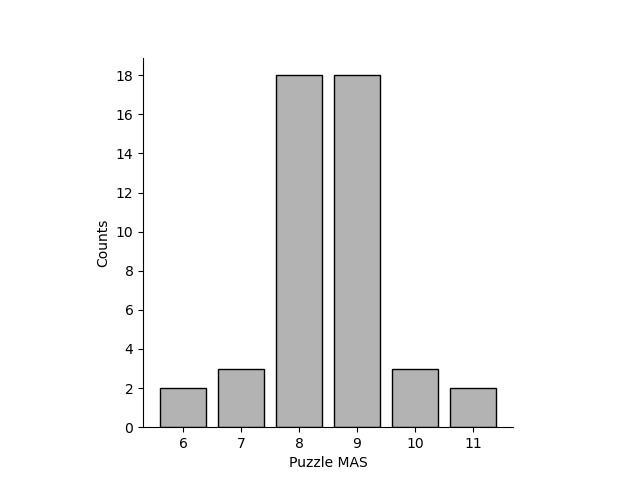

In [10]:
%matplotlib widget

n_mas = single_condition_data[single_condition_data.subjects==2].groupby(['mas'])['mas'].count() # only undo condition

fig, axs = plt.subplots(1, 1)
axs.bar(range(6,12), n_mas,
        color = (.7,.7,.7),
        edgecolor = 'k')## puzzle MAS

### histogram of MAS/remaining budget, numFullUndo',)
axs.set_ylabel('Counts') 
axs.set_yticks(list(range(0, 20, 2)))
axs.set_xlabel('Puzzle MAS')
# change size ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio(), adjustable='box')
#plt.show()
fig.savefig(out_dir + 'count_mas_puzzle.png', dpi=300, bbox_inches='tight')

## Number of connected cities distribution

# Undo - Error

In [86]:
# index before undo/not undo, but the possibility of undo cannot be 0
def get_undo_data(df, error_condition):
    # Use query method for cleaner condition checking
    condition = f"({error_condition}) & (submit != 1) & (currNumCities != 0)"
    index = df.query(condition).index
    undo_data = df.loc[index + 1, ["subjects", "firstUndo",'lastUndo', "allMAS"]]
    # Direct assignment from the same dataframe using .loc to avoid chaining
    columns_to_copy = ["currNumCities", "N_more", "severityOfErrors", "cumulative_error", "missed_reward", "error_rate", "checkEnd"]
    for column in columns_to_copy:
        undo_data[column] = df.loc[index, column].values
    undo_data['sequential_undo'] = (undo_data.firstUndo != undo_data.lastUndo)&(undo_data.firstUndo == 1)
    undo_data['single_undo'] = (undo_data.firstUndo == undo_data.lastUndo)&(undo_data.firstUndo == 1)
    return undo_data

# Assuming sc_data_choice_level is your DataFrame
undo_noerror = get_undo_data(sc_data_choice_level, "cumulative_error==0")
undo_error = get_undo_data(sc_data_choice_level, "cumulative_error!=0")
undo_noerror_avg = undo_noerror.groupby("subjects")['firstUndo'].mean()
undo_error_avg = undo_error.groupby("subjects")['firstUndo'].mean()

print(len(undo_noerror_avg))
print(len(undo_error_avg))

move_undo_noerror = get_undo_data(sc_data_choice_level, "severityOfErrors==0")
move_undo_error = get_undo_data(sc_data_choice_level, "severityOfErrors!=0")
move_undo_noerror_avg = move_undo_noerror.groupby("subjects")['firstUndo'].mean()
move_undo_error_avg = move_undo_error.groupby("subjects")['firstUndo'].mean()
print(len(move_undo_noerror_avg))
print(len(move_undo_error_avg))

undo_data = pd.concat([undo_error, undo_noerror])

100
100
100
100


## Binary error

### state/move Hit/falsealarm/balancedaccuracy 

#### scatter plot

#### box plot

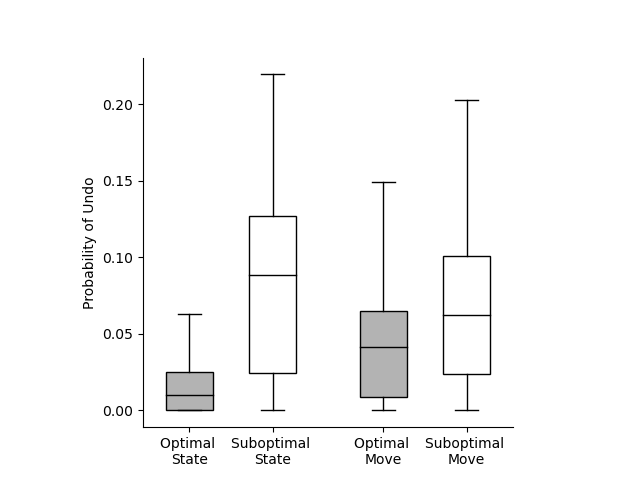

In [15]:
# This uses all undo
# plot in a scatter plot
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# box plot
bx = axs.boxplot([undo_noerror_avg, undo_error_avg,
             move_undo_noerror_avg, move_undo_error_avg],
                widths=0.5,
                positions =[1,1.9,3.1,4],
                patch_artist=True,
                showfliers=False,
                boxprops=dict(color='k'),
                whiskerprops=dict(color='k'),
                capprops=dict(color='k'),
                medianprops=dict(color='k'))

colors = [(.7,.7,.7),'w',(.7,.7,.7),'w']
for patch, color in zip(bx['boxes'], colors):
    patch.set_facecolor(color)

axs.set_ylabel('Probability of Undo')
axs.set_xticks([1,1.9,3.1,4])
axs.set_xticklabels(labels = ['Optimal \nState',
                              'Suboptimal \nState',
                              'Optimal \nMove',
                              'Suboptimal \nMove'])#,fontsize=18

# set ratio to be 1:1
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'undo_all_type.png', dpi=300, bbox_inches='tight')

##### statistics

In [16]:
stat1, p1 = wilcoxon(undo_noerror_avg, undo_error_avg, alternative = 'less')
print(stat1, p1)
# axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))
stat1, p1 = wilcoxon(move_undo_noerror_avg, move_undo_error_avg, alternative = 'less')
print(stat1, p1)
# axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))
stat1, p1 = wilcoxon(undo_noerror_avg, move_undo_noerror_avg)
print(stat1, p1)
stat1, p1 = wilcoxon(undo_error_avg, move_undo_error_avg)
print(stat1, p1)

6.0 1.0664881064858784e-16
995.0 1.1431021167310266e-05
18.0 1.5010371865330967e-15
1125.0 0.00020574144352740787


#### two balanced accuracy comparison

### steps Hit/false alarm 

#### suboptimal state

##### puzzle MAS

##### terminal or not

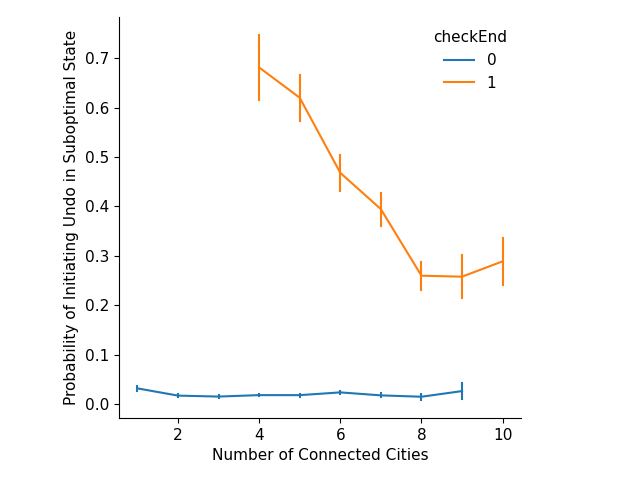

In [270]:
# This uses all undo
df_plot = undo_error.groupby(["subjects","checkEnd","currNumCities"])['undo'].mean().reset_index()
count_df = df_plot.groupby(["checkEnd","currNumCities"])['undo'].count().reset_index()
# filter df_plot if count_df > 10
df_plot = df_plot.merge(count_df, on = ["checkEnd","currNumCities"], how = "left", suffixes = ("","_count"))
df_plot = df_plot[df_plot['undo_count'] > 30]
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='undo', 
             hue = "checkEnd", 
        #      color = "k",
             data = df_plot, 
             errorbar = "se",
             err_style = "bars")
# axs.set_yticks(np.linspace(0,0.2,5))
# axs.set_ylim([0,0.2])
axs.set(xlabel='Number of Connected Cities', 
        ylabel='Probability of Initiating Undo in Suboptimal State')
# set legend title
axs.legend(title = "checkEnd", frameon=False, loc='upper right')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_error_step_terminal.png', dpi=300, bbox_inches='tight')

#### suboptimal move

#### optimal state

##### allMAS

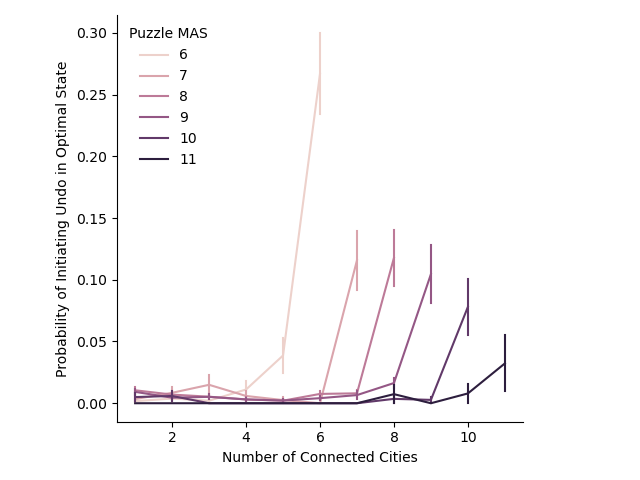

In [17]:
# This uses all undo
df_plot = undo_noerror.groupby(["subjects","allMAS", "currNumCities"])['undo'].mean().reset_index()
count_df = df_plot.groupby(["allMAS","currNumCities"])['undo'].count().reset_index()
# filter df_plot if count_df > 10
df_plot = df_plot.merge(count_df, on = ["allMAS","currNumCities"], how = "left", suffixes = ("","_count"))
df_plot = df_plot[df_plot['undo_count'] > 30]
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='undo', 
             hue = "allMAS", 
             data = df_plot, 
             errorbar = "se",
             err_style = "bars")
# axs.set_yticks(np.linspace(0,0.2,5))
# axs.set_ylim([0,0.2])
axs.set(xlabel='Number of Connected Cities', 
        ylabel='Probability of Initiating Undo in Optimal State')
# set legend title
axs.legend(title = "Puzzle MAS", frameon=False, loc='upper left')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_noerror_step.png', dpi=300, bbox_inches='tight')

##### terminal

In [267]:
# This uses all undo
df_plot = undo_noerror.groupby(["subjects","checkEnd", "currNumCities"])['undo'].mean().reset_index()
count_df = df_plot.groupby(["checkEnd","currNumCities"])['undo'].count().reset_index()
# filter df_plot if count_df > 10
df_plot = df_plot.merge(count_df, on = ["checkEnd","currNumCities"], how = "left", suffixes = ("","_count"))
df_plot = df_plot[df_plot['undo_count'] > 30]
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='undo', 
             hue = "checkEnd", 
             data = df_plot, 
             errorbar = "se",
             err_style = "bars")
# axs.set_yticks(np.linspace(0,0.2,5))
# axs.set_ylim([0,0.2])
axs.set(xlabel='Number of Connected Cities', 
        ylabel='Probability of Initiating Undo in Optimal State')
# set legend title
axs.legend(title = "checkEnd", frameon=False, loc='upper left')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_noerror_step.png', dpi=300, bbox_inches='tight')

NameError: name 'undo_noerror' is not defined

#### optimal move

### puzzle MAS Hit/false alarm 

### balanced accuracy correlation with basic condition

#### state-level

In [17]:
# This uses all undo
TNR = 1 - undo_noerror_avg # True Negative Rate 
balanced_accuracy = (undo_error_avg + TNR)/2

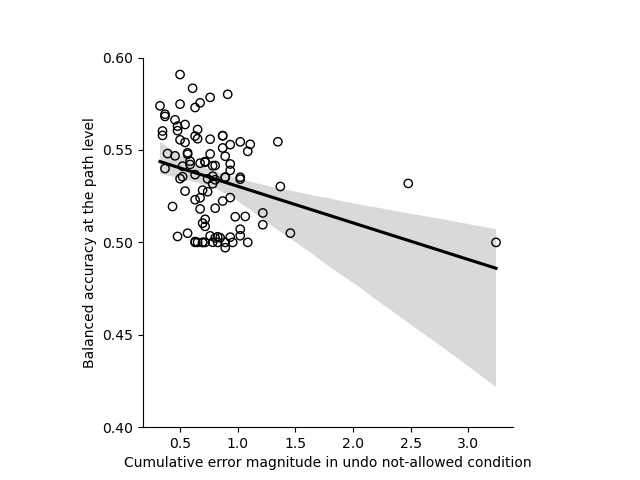

In [21]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()

# plot the correlation
fig, axs = plt.subplots(1, 1)

axs.scatter( score, balanced_accuracy,               
             edgecolor="black",
                facecolor="None")
# add regplot line
sns.regplot(x=score, y=balanced_accuracy, ax=axs, ci=95, scatter=False, color='black')

# set yticks
axs.set_yticks(np.arange(0.4, 0.65, 0.05))

axs.set_xlabel('Cumulative error magnitude in undo not-allowed condition')
axs.set_ylabel('Balanced accuracy at the path level') #Difference in undo initiation probability \nbetween optimal and suboptimal paths

axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'path_balanced_acc_correlation.png', dpi=300, bbox_inches='tight')

In [22]:
# correlation between efficiency and score
spearmanr(score, balanced_accuracy)

SpearmanrResult(correlation=-0.38182817993772894, pvalue=8.85945768963304e-05)

#### move-level

In [18]:
move_TNR = 1 - move_undo_noerror_avg # True Negative Rate 
balanced_accuracy_move = (move_undo_error_avg + move_TNR)/2

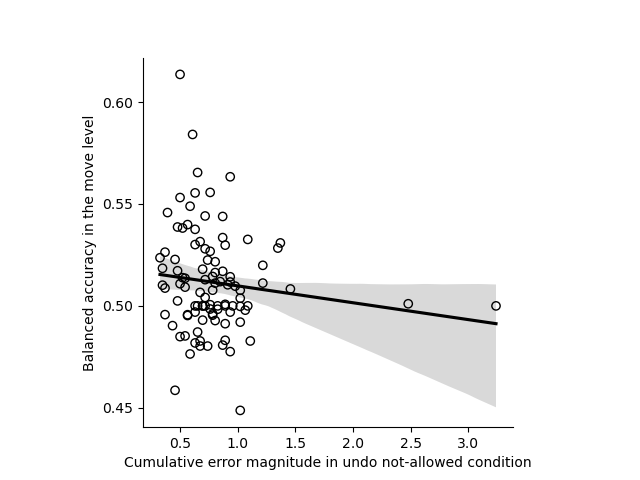

In [24]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()

# plot the correlation
fig, axs = plt.subplots(1, 1)

axs.scatter( score, balanced_accuracy_move,               
             edgecolor="black",
             facecolor="None")
axs.set_yticks(np.arange(0.4, 0.65, 0.05))

# add regplot line
sns.regplot(x=score, y=balanced_accuracy_move, ax=axs, ci=95, scatter=False, color='black')

axs.set_xlabel('Cumulative error magnitude in undo not-allowed condition')
axs.set_ylabel('Balanced accuracy in the move level') # Difference in undo initiation probability \nbetween optimal and suboptimal moves

axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir + 'move_balanced_acc_correlation.png', dpi=300, bbox_inches='tight')

In [25]:
# correlation between efficiency and score
spearmanr(score, balanced_accuracy_move)

SpearmanrResult(correlation=-0.13378809589916837, pvalue=0.18449713269822837)

## Error magnitude

### state-level error mganitude

#### Probability, all

In [37]:
undo_data_avg = undo_data.groupby(["subjects","cumulative_error"])["firstUndo"].mean().reset_index()
undo_data_avg.groupby(["cumulative_error"])["firstUndo"].count()

cumulative_error
0    100
1    100
2    100
3     81
4     42
5      8
6      3
8      1
Name: firstUndo, dtype: int64

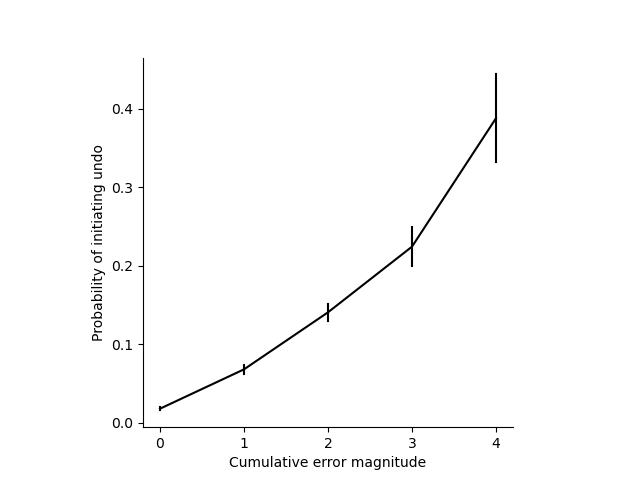

In [39]:
# This uses all undo
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='cumulative_error', y='firstUndo', 
             data = undo_data_avg[undo_data_avg.cumulative_error<=4],
             color = 'k',
             err_style = "bars",
             errorbar = "se")

axs.set_xticks([0,1,2,3,4])
# axs.set_ylim(0,0.15)
axs.set(xlabel='Cumulative error magnitude', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_cumulative_error_magnitude.png', dpi=300, bbox_inches='tight')

##### statistics

In [36]:
%%R -i undo_data,out_dir2
undo_data$subjects <- as.factor(undo_data[,"subjects"])

model_undo = lme4::glmer(firstUndo ~  1 + cumulative_error  + (1 |subjects),
                                  data = undo_data, family = "binomial")

save(model_undo, undo_data, file=file.path(out_dir2, file=paste("model_undo_cumulative_error.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + cumulative_error + (1 | subjects)
   Data: undo_data

     AIC      BIC   logLik deviance df.resid 
 17679.7  17706.0  -8836.8  17673.7    47227 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3172 -0.2564 -0.1728 -0.1052 17.1219 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.769    1.33    
Number of obs: 47230, groups:  subjects, 100

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -4.29558    0.14247  -30.15   <2e-16 ***
cumulative_error  0.90912    0.02234   40.70   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cumultv_rrr -0.194


#### Probability, terminal or non-terminal

In [43]:
undo_data_end_avg = undo_data.groupby(["subjects","cumulative_error", "checkEnd"])["firstUndo"].mean().reset_index()
undo_data_end_avg.groupby(["cumulative_error", "checkEnd"])["firstUndo"].count()

cumulative_error  checkEnd
0                 0           100
                  1            99
1                 0           100
                  1            99
2                 0           100
                  1           100
3                 0            78
                  1            79
4                 0            37
                  1            37
5                 0             7
                  1             7
6                 0             3
                  1             1
8                 1             1
Name: firstUndo, dtype: int64

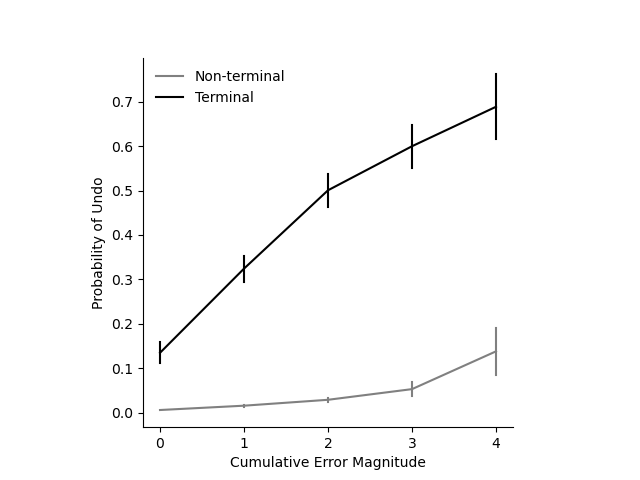

In [47]:
# This uses all undo
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='cumulative_error', y='firstUndo', 
             data = undo_data_end_avg[undo_data_end_avg.cumulative_error<5], 
             hue = "checkEnd",
             palette = ["grey","k"],
             err_style = "bars",
             errorbar = "se")

plt.legend(labels=['Non-terminal','Terminal'], loc='upper left')

axs.set_xticks([0,1,2,3,4])
# axs.set_ylim(0,0.15)

axs.set(xlabel='Cumulative Error Magnitude', ylabel='Probability of Undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_terminal_cumulative_error.png', dpi=300, bbox_inches='tight')

##### statistics

In [48]:
%%R -i undo_data,out_dir2
undo_data$subjects <- as.factor(undo_data[,"subjects"])

model_undo = lme4::glmer(firstUndo ~  1 + cumulative_error*checkEnd  + (1 |subjects),
                                  data = undo_data, family = "binomial")

save(model_undo, undo_data, file=file.path(out_dir2, file=paste("model_undo_cumulative_error_checkEnd.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + cumulative_error * checkEnd + (1 | subjects)
   Data: undo_data

     AIC      BIC   logLik deviance df.resid 
 11328.3  11372.1  -5659.2  11318.3    47225 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-9.503 -0.145 -0.092 -0.044 51.363 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 3.687    1.92    
Number of obs: 47230, groups:  subjects, 100

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -6.01574    0.20912  -28.77   <2e-16 ***
cumulative_error           0.66099    0.04337   15.24   <2e-16 ***
checkEnd                   3.30307    0.07644   43.21   <2e-16 ***
cumulative_error:checkEnd  0.61875    0.06140   10.08   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            

#### Probability, sequential or single

### move-level error

#### Probability, terminal or non-terminal

#### Probability, sequential or single

In [50]:
allUndo_sub = undo_data.groupby(['subjects','severityOfErrors'])['firstUndo'].mean().reset_index()
singleUndo_sub = undo_data.groupby(['subjects','severityOfErrors'])['single_undo'].mean().reset_index()
sequentialundo_sub = undo_data.groupby(['subjects','severityOfErrors'])['sequential_undo'].mean().reset_index()
print(allUndo_sub.groupby(['severityOfErrors'])['subjects'].count().reset_index())

   severityOfErrors  subjects
0                 0       100
1                 1       100
2                 2        98
3                 3        65
4                 4        22
5                 5         3
6                 6         3


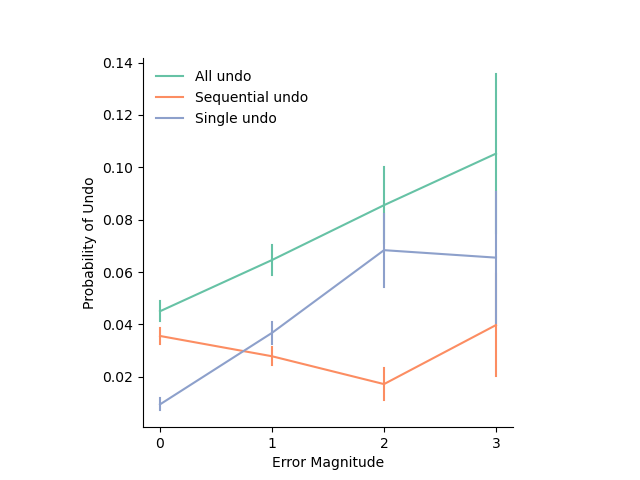

In [56]:
# This uses all undo
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='severityOfErrors', y='firstUndo', 
             data = allUndo_sub[allUndo_sub.severityOfErrors<=3], 
             color = '#66c2a5',
             err_style = "bars",
             errorbar = "se")
sns.lineplot(x='severityOfErrors', y='sequential_undo',
             data = sequentialundo_sub[sequentialundo_sub.severityOfErrors<=3],
             color = '#fc8d62',
             err_style = "bars",
             errorbar = "se")
sns.lineplot(x='severityOfErrors', y='single_undo',
                data = singleUndo_sub[singleUndo_sub.severityOfErrors<=3],
                color = '#8da0cb',
                err_style = "bars",
                errorbar = "se")

# add manual legend
plt.legend(labels=['All undo','Sequential undo','Single undo'], loc='upper left')

axs.set_xticks([0,1,2,3])
# axs.set_ylim(0,0.15)

axs.set(xlabel='Error Magnitude', ylabel='Probability of Undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'sequential_error_magnitude.png', dpi=300, bbox_inches='tight')

##### statistics

In [57]:
%%R -i undo_data,out_dir2
undo_data$subjects <- as.factor(undo_data[,"subjects"])

model_undo = lme4::glmer(firstUndo ~  1 + severityOfErrors  + (1 |subjects),
                                  data = undo_data, family = "binomial")

save(model_undo, undo_data, file=file.path(out_dir2, file=paste("model_undo_error_magnitude.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + severityOfErrors + (1 | subjects)
   Data: undo_data

     AIC      BIC   logLik deviance df.resid 
 19246.8  19273.1  -9620.4  19240.8    47227 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.6700 -0.2819 -0.2280 -0.1184 13.0270 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.414    1.189   
Number of obs: 47230, groups:  subjects, 100

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -3.51328    0.12674 -27.720  < 2e-16 ***
severityOfErrors  0.26733    0.04371   6.117 9.55e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
svrtyOfErrr -0.059


In [58]:
%%R -i undo_data,out_dir2
undo_data$subjects <- as.factor(undo_data[,"subjects"])

model_undo = lme4::glmer(sequential_undo ~  1 + severityOfErrors + (1 |subjects),
                                  data = undo_data, family = "binomial")

save(model_undo, undo_data, file=file.path(out_dir2, file=paste("model_sequential_undo_error_magnitude.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: sequential_undo ~ 1 + severityOfErrors + (1 | subjects)
   Data: undo_data

     AIC      BIC   logLik deviance df.resid 
 16031.7  16058.0  -8012.9  16025.7    47227 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.3744 -0.2495 -0.2018 -0.0937 14.2843 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.933    1.39    
Number of obs: 47230, groups:  subjects, 100

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -3.90851    0.15178 -25.751  < 2e-16 ***
severityOfErrors -0.29097    0.07266  -4.005 6.21e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
svrtyOfErrr -0.040


In [59]:
%%R -i undo_data,out_dir2
undo_data$subjects <- as.factor(undo_data[,"subjects"])

model_undo = lme4::glmer(single_undo ~  1 + severityOfErrors + (1 |subjects),
                                  data = undo_data, family = "binomial")

save(model_undo, undo_data, file=file.path(out_dir2, file=paste("model_single_undo_error_magnitude.RData", sep="")))
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: single_undo ~ 1 + severityOfErrors + (1 | subjects)
   Data: undo_data

     AIC      BIC   logLik deviance df.resid 
  5398.0   5424.3  -2696.0   5392.0    47227 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9399 -0.1012 -0.0783 -0.0572 21.0030 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.214    1.102   
Number of obs: 47230, groups:  subjects, 100

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -5.2670     0.1345  -39.15   <2e-16 ***
severityOfErrors   0.9191     0.0556   16.53   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
svrtyOfErrr -0.187


#### Proportion, sequential or single, mapMAS

In [64]:
only_undo_df = undo_data.loc[(undo_data.single_undo == 1)|(undo_data.sequential_undo == 1)]
singleUndo_sub = only_undo_df.groupby(['subjects','severityOfErrors','allMAS'])['single_undo'].mean().reset_index()
singleUndo_sub.groupby(['severityOfErrors','allMAS'])['subjects'].count().reset_index()

,severityOfErrors,allMAS,subjects
0,0,6,56
1,0,7,64
2,0,8,82
3,0,9,78
4,0,10,40
5,0,11,39
6,1,6,12
7,1,7,20
8,1,8,48
9,1,9,56


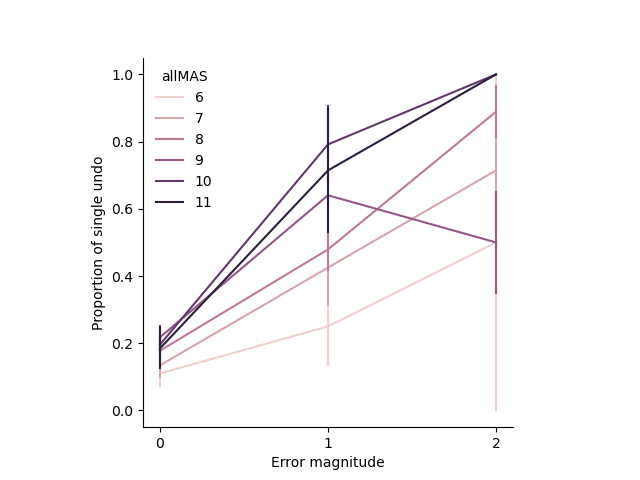

In [63]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
lineplot = sns.lineplot(x='severityOfErrors', y='single_undo', 
             data = singleUndo_sub[singleUndo_sub.severityOfErrors<=2], 
             hue = "allMAS",
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks([0,1,2])
axs.set_yticks([0,0.2,0.4,0.6,0.8,1])

n_sub = singleUndo_sub[singleUndo_sub.severityOfErrors<=2].groupby(['severityOfErrors'])['subjects'].count().reset_index()
# add each n_sub to each dot on the line,  y uses the position of each dot
# loop through lineplot dots
# for i in range(len(n_sub)):
#     # add text to lineplot
#     lineplot.text(x = n_sub.severityOfErrors[i], # x-coordinate position of data label, padded to be right of the scatterplot
#                   y = singleUndo_sub[singleUndo_sub.severityOfErrors<=2].groupby(['severityOfErrors'])['singleUndo'].mean()[i]+0.1, # y-coordinate position of data label, padded to be above scatterplot
#                   s = "N="+str(n_sub.subjects[i]), # data label, formatted to ignore decimals
#                   color = 'black') # set colour of line


#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel='Error magnitude', ylabel='Proportion of single undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'prop_single_error_magnitude.png', dpi=300, bbox_inches='tight')

In [65]:
%%R -i only_undo_df,out_dir2
only_undo_df$subjects <- as.factor(only_undo_df[,"subjects"])

# lambda = 0.33
# error_undo_df$severityOfErrors_lamda <- (error_undo_df$severityOfErrors^lambda-1)/lambda
model_undo = lme4::glmer(single_undo ~  1 + severityOfErrors + (1 |subjects),
                                  data = only_undo_df, family = "binomial")

save(model_undo, only_undo_df, file=file.path(out_dir2, file=paste("model_prop_single_undo_error_magnitude.RData", sep="")))
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: single_undo ~ 1 + severityOfErrors + (1 | subjects)
   Data: only_undo_df

     AIC      BIC   logLik deviance df.resid 
  2076.2   2093.8  -1035.1   2070.2     2657 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-10.5690  -0.3739  -0.3001  -0.2164   5.1250 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 1.981    1.407   
Number of obs: 2660, groups:  subjects, 90

Fixed effects:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.7879     0.1756  -10.18   <2e-16 ***
severityOfErrors   1.7452     0.1272   13.71   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
svrtyOfErrr -0.198


## Missed reward

## Error rate

# Undo - terminal state

### Errors across steps

In [70]:
def get_error_data(df):
    # Use query method for cleaner condition checking
    condition = f"(submit != 1) & (currNumCities != 0)"
    index = df.query(condition).index
    undo_data = df.loc[index,:]
    # Direct assignment from the same dataframe using .loc to avoid chaining
    columns_to_copy = ["currNumCities","N_more"]
    for column in columns_to_copy:
        undo_data[column] = df.loc[index-1, column].values
    return undo_data

data_cond0_outcome = get_error_data(data_choice_level[(data_choice_level['condition']==0)])
data_cond1_outcome = get_error_data(sc_data_choice_level)
data_cond1_undo_outcome = get_error_data(data_subset_before1undoonly)

In [80]:
%%R -i data_cond0_outcome,data_cond1_outcome,out_dir2
data_cond0_outcome$subjects <- as.factor(data_cond0_outcome[,"subjects"])
data_cond0_outcome$allMAS <- as.factor(data_cond0_outcome[,"allMAS"])
data_cond1_outcome$subjects <- as.factor(data_cond1_outcome[,"subjects"])
data_cond1_outcome$allMAS <- as.factor(data_cond1_outcome[,"allMAS"])

#### Basic condition (supp)

In [76]:
error_sub = data_cond0_outcome.groupby(['subjects','currNumCities'])['error'].mean().reset_index()
# count number of subjects in each prevNumCities and allMAS
# error_sub.groupby(['prevNumCities',"allMAS"])['error'].count().reset_index()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


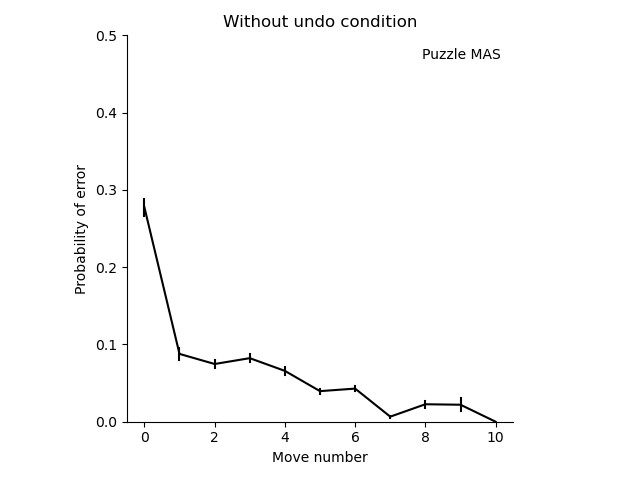

In [77]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='currNumCities', y='error', 
            #  hue = "allMAS", 
             color = "k",
             data = error_sub, 
             errorbar = "se",
             err_style = "bars")
axs.set(xlabel='Move number', ylabel='Probability of error')
axs.set_ylim(0,0.5)
axs.legend(title = "Puzzle MAS", 
              frameon=False)
axs.set_title("Without undo condition")
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'error_step_basic_condition.png', dpi=300, bbox_inches='tight')

##### statistics

In [303]:
%%R -i
model_error = lme4::glmer(error ~  1 + currNumCities + (1 |subjects),
                                  data = data_cond0_outcome, family = "binomial")
save(model_error, data_cond0_outcome, file=file.path(out_dir2, file=paste("model_error_step_basic_condition.RData", sep="")))
summary(model_error)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: error ~ 1 + prevNumCities + allMAS + (1 | subjects)
   Data: 
data_cond0_outcome[(data_cond0_outcome$allMAS == 8) | (data_cond0_outcome$allMAS ==  
    9), ]

     AIC      BIC   logLik deviance df.resid 
 14572.4  14605.3  -7282.2  14564.4    27387 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0427 -0.3540 -0.2325 -0.1478  8.7125 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.1166   0.3415  
Number of obs: 27391, groups:  subjects, 100

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.42462    0.05214  -27.32  < 2e-16 ***
prevNumCities -0.40420    0.01198  -33.73  < 2e-16 ***
allMAS9        0.16285    0.04450    3.66 0.000252 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) prvNmC
prevNumCits -

#### Undo condition

##### cumulative error

##### error magnitude

In [78]:
error_sub = data_cond1_outcome.groupby(['subjects','currNumCities'])['severityOfErrors'].mean().reset_index()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


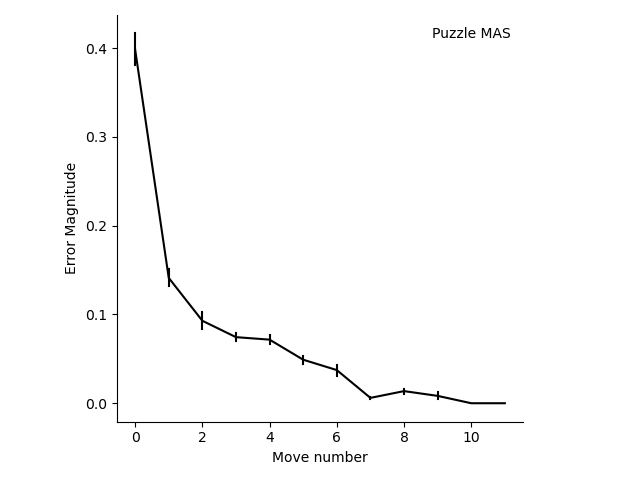

In [79]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='currNumCities', y='severityOfErrors', 
            #  hue = "allMAS", 
             data = error_sub, 
             errorbar = "se",
             err_style = "bars",
             color = "k"
            #  palette = ['red','blue']
             )
axs.set(xlabel='Move number', ylabel='Error Magnitude')
# axs.set_ylim(0,0.5)
# axs.set_xticks([0,1,2,3,4,5,6,7,8])
axs.legend(title = "Puzzle MAS", 
              frameon=False)
# axs.set_title("With undo condition")
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'severityOfErrors_step_undo_condition.png', dpi=300, bbox_inches='tight')

In [25]:
%%R 
model_error = lme4::glmer(severityOfErrors ~  1 + currNumCities + (1 |subjects),
                                  data = data_cond1_outcome, family = "gaussian")
save(model_error, data_cond1_outcome, file=file.path(out_dir2, file=paste("model_severityOfErrors_step_undo_condition.RData", sep="")))
summary(model_error)

Linear mixed model fit by REML ['lmerMod']
Formula: severityOfErrors ~ 1 + prevNumCities + (1 | subjects)
   Data: data_cond1_outcome

REML criterion at convergence: 41701.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9607 -0.4058 -0.2109 -0.0069 16.6982 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.004221 0.06497 
 Residual             0.120206 0.34671 
Number of obs: 57533, groups:  subjects, 100

Fixed effects:
                Estimate Std. Error t value
(Intercept)    0.2301784  0.0070572   32.62
prevNumCities -0.0343329  0.0006253  -54.91

Correlation of Fixed Effects:
            (Intr)
prevNumCits -0.321


##### error

In [82]:
error_sub = data_cond1_outcome.groupby(['subjects','currNumCities'])['error'].mean().reset_index()

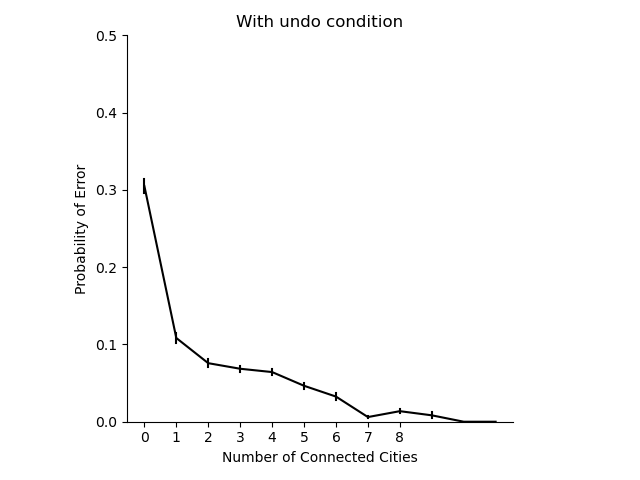

In [83]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)
# select error_sub when allMAS is 9 or 10
sns.lineplot(x='currNumCities', y='error', 
            #  hue = "allMAS", 
             color = "k",
             data = error_sub, # .loc[(error_sub.allMAS==8)|(error_sub.allMAS==9),:]
             errorbar = "se",
             err_style = "bars",
            #  palette = ['red','blue']
             )
axs.set(xlabel='Number of Connected Cities', ylabel='Probability of Error')
axs.set_ylim(0,0.5)
axs.set_xticks([0,1,2,3,4,5,6,7,8])
# axs.legend(title = "Puzzle MAS", frameon=False)
axs.set_title("With undo condition")
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'error_step_undo_condition.png', dpi=300, bbox_inches='tight')

##### statistics

In [266]:
%%R 
model_error = lme4::glmer(error ~  1 + currNumCities + (1 |subjects),
                                  data = data_cond1_outcome, family = "binomial")
save(model_error, data_cond1_outcome, file=file.path(out_dir2, file=paste("model_error_step_undo_condition.RData", sep="")))
summary(model_error)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: error ~ 1 + prevNumCities + (1 | subjects)
   Data: data_cond1_outcome

     AIC      BIC   logLik deviance df.resid 
 27606.0  27632.9 -13800.0  27600.0    57530 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0524 -0.3217 -0.2063 -0.1301 16.1670 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.08051  0.2838  
Number of obs: 57533, groups:  subjects, 100

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.196736   0.037219  -32.15   <2e-16 ***
prevNumCities -0.459808   0.008891  -51.72   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
prevNumCits -0.462


#### Given undo (supp)

##### statistics

### Undo at terminal

#### Across step

##### puzzle MAS

##### terminal or not

In [89]:
firstUndo_sub = undo_data.groupby(['subjects','currNumCities',"checkEnd"])['firstUndo'].mean().reset_index()
count_df = firstUndo_sub.groupby(["currNumCities","checkEnd"])['firstUndo'].count().reset_index()
firstUndo_sub = firstUndo_sub.merge(count_df, on = ["currNumCities","checkEnd"], how = "left", suffixes = ("","_count"))
# firstUndo_sub = firstUndo_sub[firstUndo_sub['firstUndo_count'] > 30]

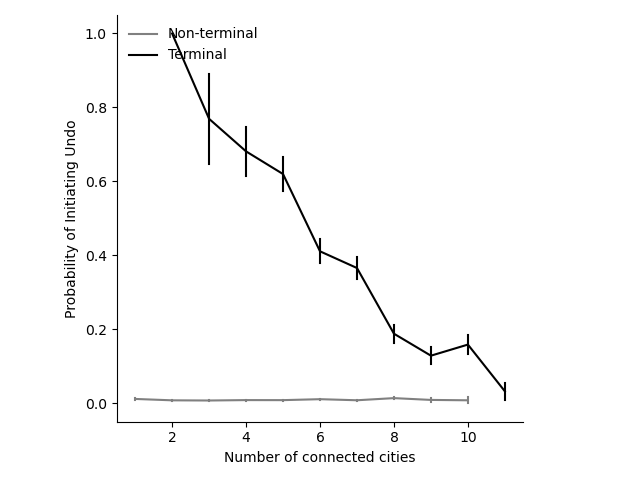

In [93]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='firstUndo', 
             hue = "checkEnd", 
             data = firstUndo_sub,
             errorbar = "se",
             err_style = "bars",
             palette = ['grey','k']
             )
axs.set(xlabel='Number of connected cities', 
        ylabel='Probability of Initiating Undo')
# set legend title
axs.legend(labels=['Non-terminal','Terminal'], frameon=False, loc='upper left')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_step_terminal.png', dpi=300, bbox_inches='tight')

###### statistics

In [92]:
%%R -i undo_data,out_dir2
# state_df_1undo$subjects <- toString(state_df_1undo[,"subjects"])
undo_data$checkEnd <- as.factor(undo_data[,"checkEnd"])

model_undo = glm(firstUndo ~  1 + currNumCities * checkEnd + (1 |subjects),
                                  data = undo_data, family = binomial())

save(model_undo, undo_data, file=file.path(out_dir2, file=paste("model_undo_step_checkEnd.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)


Call:
glm(formula = firstUndo ~ 1 + currNumCities * checkEnd + (1 | 
    subjects), family = binomial(), data = undo_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0017  -0.1527  -0.1492  -0.1458   3.0242  

Coefficients: (1 not defined because of singularities)
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -4.58586    0.09318 -49.214   <2e-16 ***
currNumCities            0.02340    0.02051   1.141    0.254    
checkEnd1                8.19851    0.19646  41.731   <2e-16 ***
1 | subjectsTRUE              NA         NA      NA       NA    
currNumCities:checkEnd1 -0.60814    0.03108 -19.564   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 21549  on 57532  degrees of freedom
Residual deviance: 13578  on 57529  degrees of freedom
AIC: 13586

Number of Fisher Scoring iterations: 7



#### Across N_more

In [52]:
firstUndo_sub = state_df_1undo.groupby(['subjects','N_more', "allMAS"])['firstUndo'].mean().reset_index()
count_df = firstUndo_sub.groupby(["N_more","allMAS"])['firstUndo'].count().reset_index()
# filter df_plot if count_df > 10
firstUndo_sub = firstUndo_sub.merge(count_df, on = ["N_more","allMAS"], how = "left", suffixes = ("","_count"))
# firstUndo_sub = firstUndo_sub[firstUndo_sub['firstUndo_count'] > 30]

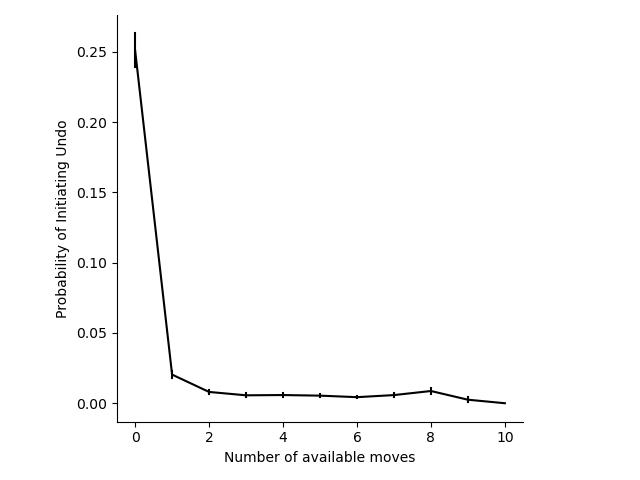

In [53]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='N_more', y='firstUndo', 
        #      hue = "allMAS", 
             color = 'k',
             data = firstUndo_sub,#.loc[(firstUndo_sub.allMAS==8)|(firstUndo_sub.allMAS==9),:], 
             errorbar = "se",
             err_style = "bars"
             #palette = ['red','blue']
             )
# axs.set_yticks(np.linspace(0,0.2,5))
# axs.set_ylim([0,0.2])
axs.set(xlabel='Number of available moves', 
        ylabel='Probability of Initiating Undo')
# set legend title
# axs.legend(title = "Puzzle MAS", frameon=False, loc='upper right')
axs.set_aspect(1/axs.get_data_ratio())
plt.tight_layout()
fig.savefig(out_dir+'undo_nmore.png', dpi=300, bbox_inches='tight')

#### Do people make more errors from terminal-1 to terminal?

In [54]:
terminal_idx = state_df_1undo[state_df_1undo.checkEnd==1].index 
error_1before_terminal = state_df_1undo.loc[terminal_idx-1, ["subjects", "cumulative_error"]].reset_index(drop=True).groupby(["subjects"])['cumulative_error'].mean().reset_index()
error_at_terminal = state_df_1undo.loc[terminal_idx, ["subjects", "cumulative_error"]].reset_index(drop=True).groupby(["subjects"])['cumulative_error'].mean().reset_index()

wilcoxon(error_1before_terminal.cumulative_error, error_at_terminal.cumulative_error)

WilcoxonResult(statistic=0.0, pvalue=5.5599817833409e-17)

#### Number of undo given terminal or not

##### Proportion

##### Probability

### More sequential undo from terminal

In [57]:
singleundo = (data_choice_level.firstUndo == 1)&(data_choice_level.lastUndo == 1)
end_singleundo = data_choice_level.loc[data_choice_level.loc[singleundo,:].index-1, ["checkEnd",'subjects','puzzleID','allMAS']]
# end_singleundo = end_singleundo.loc[(end_singleundo.allMAS==8)|(end_singleundo.allMAS==9),:]
end_singleundo['singleUndo'] = 1
end_singleundo['sequentialUndo'] = 0

sequentialundo = (data_choice_level.firstUndo == 1)&(data_choice_level.lastUndo != 1)
end_sequentialundo = data_choice_level.loc[data_choice_level.loc[sequentialundo,:].index-1,["checkEnd",'subjects','puzzleID','allMAS']]
# end_sequentialundo = end_sequentialundo.loc[(end_sequentialundo.allMAS==8)|(end_sequentialundo.allMAS==9),:]
end_sequentialundo['singleUndo'] = 0
end_sequentialundo['sequentialUndo'] = 1

end_undo_df = pd.concat([end_singleundo,end_sequentialundo])

# end_singleundo_avg = end_singleundo.groupby(['subjects'])['checkEnd'].mean()
# end_sequentialundo_avg = end_sequentialundo.groupby(['subjects'])['checkEnd'].mean()

print(sum(end_undo_df.checkEnd==1))
print(sum(end_undo_df.checkEnd==0))
print(sum(end_undo_df.checkEnd==1)+sum(end_undo_df.checkEnd==0))

2094
566
2660


In [58]:
sequentialUndo_sub = end_undo_df.groupby(['subjects','checkEnd'])['sequentialUndo'].mean().reset_index()

n_sub = sequentialUndo_sub.groupby(['checkEnd'])['sequentialUndo'].count().reset_index()
print(n_sub)

   checkEnd  sequentialUndo
0         0              79
1         1              84


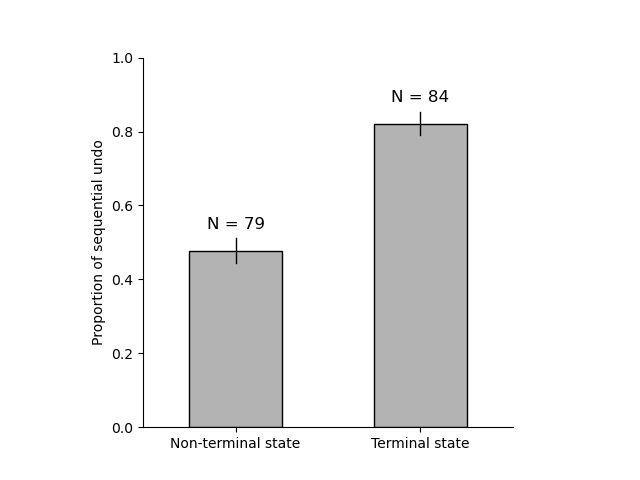

In [59]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.barplot(x='checkEnd', y='sequentialUndo', 
            data = sequentialUndo_sub, 
            color= [0.7,0.7,0.7],
            edgecolor = ['k','k','k'],
            width=.5,
            linewidth=1,
            errcolor = 'k',
            errwidth = 1,
            errorbar = "se")

axs.set_xticklabels(labels = [ "Non-terminal state" , "Terminal state"])#,fontsize=18

# add text on the upper of each bar 
for x, y, n in zip([0,1], sequentialUndo_sub.groupby(['checkEnd'])['sequentialUndo'].mean(), n_sub.sequentialUndo):
    axs.text(x, y+0.05, "N = " + str(n), ha='center', va='bottom', fontsize=12)

axs.set_yticks(np.linspace(0,1,6))
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel = '', ylabel='Proportion of sequential undo')
axs.set_aspect(1/axs.get_data_ratio(), adjustable='box')

fig.savefig(out_dir+'sequential_terminal.png', dpi=300, bbox_inches='tight')

#### statistics

In [60]:
stat1, p1 = mannwhitneyu(np.array(sequentialUndo_sub.loc[(sequentialUndo_sub.checkEnd==1),'sequentialUndo']), 
                     np.array(sequentialUndo_sub.loc[(sequentialUndo_sub.checkEnd==0),'sequentialUndo'])) 
# axs.set_title(r"$p = {0:s}$".format(as_si(p1,1)))
print(stat1, p1)

5423.0 2.194581026983643e-12


## Possible cues for error correction - terminal

In [10]:
# na can happen in branching_RT because there may be "fake undo"
def filter_dataframe(df, col1_list, col2_list):
    RT1 = []
    RT_branching = []
    RTsubmit = []
    for i, j in zip(col1_list, col2_list):
        temp = df[(df['subjects'] == i) & (df['puzzleID'] == j)]
        if not temp.empty:
            RT1.append(float(temp.loc[:,"RT1"].values))
            RT_branching.append(float(temp.loc[:,"RT_branching"].values))
            RTsubmit.append(float(temp.loc[:,"RTsubmit"].values))
        if temp.empty:
            RT1.append(np.nan)
            RT_branching.append(np.nan)
            RTsubmit.append(np.nan)
    return RT1, RT_branching, RTsubmit

def filter_dataframe_TT(df, col1_list, col2_list):
    TT = []
    for i, j in zip(col1_list, col2_list):
        temp = df[(df['subjects'] == i) & (df['puzzleID'] == j)]
        if not temp.empty:
            TT.append(float(temp.loc[:,"TT"].values))
        if temp.empty:
            TT.append(np.nan)
    return TT

In [11]:
def preprocess_data(df, condition_col, condition_val):
    df_filtered = df[df[condition_col] == condition_val].copy()
    df_before = df.loc[df_filtered.index - 1].copy()
    index_end = df_before.index[(df_before['checkEnd'] == 1)] # &(df_before['cumulative_error'] == 0)
    state = df_before.loc[index_end, ['leftover', 'allMAS', 'subjects', 'puzzleID', 'cumulative_error', "currNumCities", "budget_change", "severityOfErrors", "within_reach_change"]]
    # Add additional information from the next row
    state['lastRT'] = df.loc[index_end + 1, 'RT'].values
    state['lastRT_log'] = np.log(state['lastRT'] / 1000 + 1)
    # Remove duplicates
    # state = state.drop_duplicates()

    return state

def add_response_times(state, single_condition_data, puzzleID_order_data):
    subjects = list(state['subjects'])
    puzzleID = list(state['puzzleID'])
    # Optimize the filter_dataframe and filter_dataframe_TT functions as previously discussed
    RT1, RT_branching, _ = filter_dataframe(single_condition_data, subjects, puzzleID)
    TT = filter_dataframe_TT(puzzleID_order_data[puzzleID_order_data['condition'] == 0], subjects, puzzleID)
    state["RT1"] = RT1
    state["RT_branching"] = RT_branching
    state["TT"] = TT
    return state

# Process 'undo' and 'not undo' states
state_undo = preprocess_data(sc_data_choice_level, 'firstUndo', 1)
state_undo = add_response_times(state_undo, single_condition_data, puzzleID_order_data)
state_undo['firstUndo'] = 1

state_notundo = preprocess_data(sc_data_choice_level, 'submit', 1)
state_notundo = add_response_times(state_notundo, single_condition_data, puzzleID_order_data)
state_notundo['firstUndo'] = 0

# only use those which directly submit
# state_notundo = state_notundo[~(state_notundo['subjects'].isin(state_undo['subjects']) & state_notundo['puzzleID'].isin(state_undo['puzzleID']))]

# Combine and process final DataFrame
state_df = pd.concat([state_undo, state_notundo]).reset_index(drop=True)

# Binning 'leftover' into bins
temp,cutoff = pd.cut(state_df['leftover'], bins=[0, 7, 14, 21, 28, 35, 42, 126], labels=range(1, 8), retbins=True)
state_df['leftover_bin'] = temp
state_df['error'] = state_df['cumulative_error'] > 0

state_df['budget_change'] = abs(state_df['budget_change'].values)
temp,cutoff = pd.cut(state_df['budget_change'], bins=[16, 26, 36, 46, 56, 66, 76, 161], labels=range(1, 8), retbins=True)
state_df['budget_change_bin'] = temp

state_df['withinreach_change'] = abs(state_df['within_reach_change'].values)
temp,cutoff = pd.cut(state_df['withinreach_change'], bins=[0, 1, 2, 23], labels=range(1, 4), retbins=True)
state_df['withinreach_change_bin'] = temp

### People indeed undo from optimal state

### Current number of connected cities

#### undo

In [82]:
firstUndo_sub = state_df.groupby(['subjects','currNumCities','error'])['firstUndo'].mean().reset_index()
firstUndo_sub.groupby(['currNumCities','error'])['firstUndo'].count()

currNumCities  error
2              True       4
3              True      13
4              True      46
5              True      87
6              False     89
               True      99
7              False     70
               True     100
8              False     98
               True      99
9              False     98
               True      80
10             False     91
               True      71
11             False     62
Name: firstUndo, dtype: int64

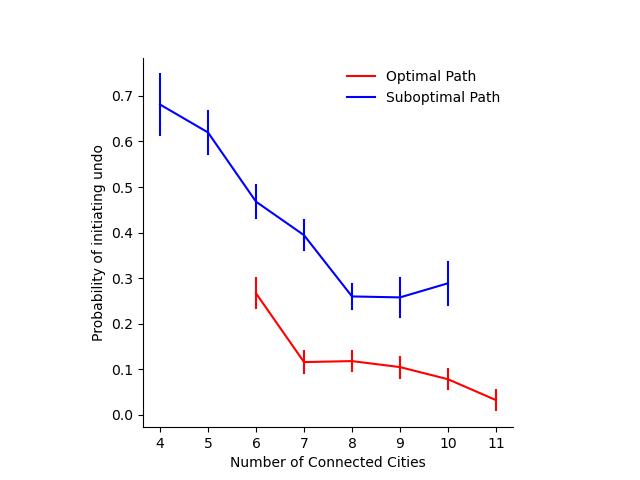

In [83]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='firstUndo', 
             data = firstUndo_sub[firstUndo_sub.currNumCities>=4],
             hue = 'error',
             palette = ['red','blue'],
             err_style = "bars",
             errorbar = "se")
# add manual legend
plt.legend(labels=['Optimal Path','Suboptimal Path'], loc='upper right')
axs.set(xlabel='Number of Connected Cities', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_currNumCities.png', dpi=300, bbox_inches='tight')
plt.show()

#### error

In [91]:
error_sub = state_df.groupby(['subjects','currNumCities'])['cumulative_error'].mean().reset_index()
error_sub.groupby(['currNumCities'])['cumulative_error'].count()

currNumCities
2       4
3      13
4      46
5      87
6      99
7     100
8      99
9      99
10     96
11     62
Name: cumulative_error, dtype: int64

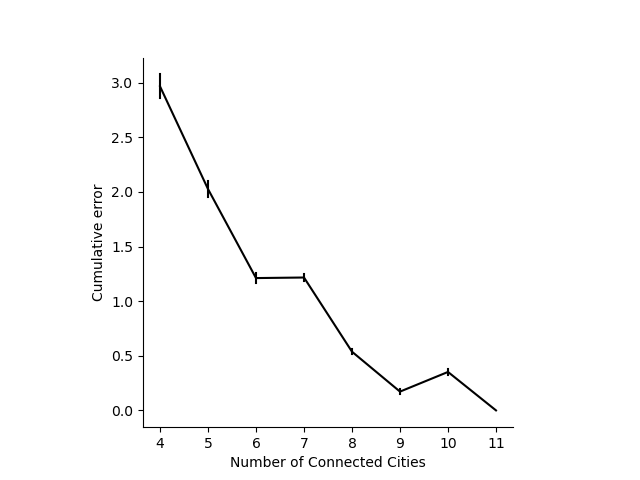

In [85]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='cumulative_error', 
             data = error_sub[error_sub.currNumCities>=4],
             color = 'k',
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# axs.set_ylim(0,0.7)
axs.set(xlabel='Number of Connected Cities', ylabel='Cumulative error')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'error_currNumCities.png', dpi=300, bbox_inches='tight')
plt.show()

#### check total RT confound (supp)

In [102]:
TT_sub = state_df.groupby(['subjects','currNumCities'])['TT'].mean().reset_index() # TT is from basic condition
TT_sub.groupby(['currNumCities'])['TT'].count()

currNumCities
2       4
3      13
4      46
5      87
6      99
7     100
8      99
9      99
10     96
11     62
Name: TT, dtype: int64

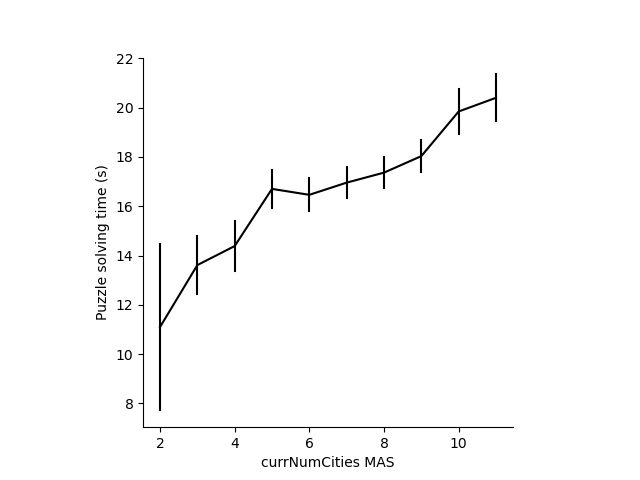

In [103]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='currNumCities', y='TT', data = TT_sub, color = 'k',
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel='currNumCities MAS', ylabel='Puzzle solving time (s)')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'TT_currNumCities.png', dpi=300, bbox_inches='tight')

In [ ]:
%%R -i state_df,out_dir2
state_df$subjects <- as.factor(state_df[,"subjects"])
state_df$TT_new <- state_df[,"TT"]^(0.5)

model_undo = lme4::glmer(firstUndo ~  1 + currNumCities + TT_new + (1 |subjects) ,
                                  data = state_df, family = binomial(link="logit"))

save(model_undo, state_df, file=file.path(out_dir2, file=paste("model_undo_optimal_mas_TT.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

#### Only cumulative error == 1

### Puzzle MAS

#### undo

In [86]:
firstUndo_sub = state_df.groupby(['subjects','allMAS','error'])['firstUndo'].mean().reset_index()
firstUndo_sub.groupby(['allMAS','error'])['firstUndo'].count()

allMAS  error
6       False     89
        True      63
7       False     70
        True      99
8       False     98
        True     100
9       False     98
        True     100
10      False     91
        True      91
11      False     62
        True      86
Name: firstUndo, dtype: int64

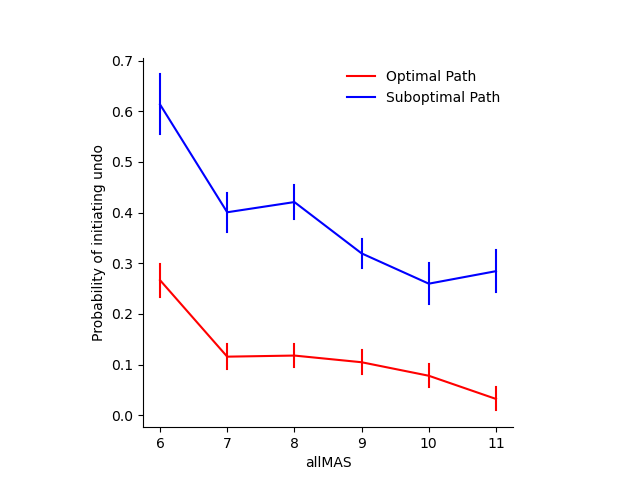

In [87]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='allMAS', y='firstUndo', 
             data = firstUndo_sub,
             hue = 'error',
             palette = ['red','blue'],
             err_style = "bars",
             errorbar = "se")
# add manual legend
plt.legend(labels=['Optimal Path','Suboptimal Path'], loc='upper right')
axs.set(xlabel='allMAS', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_MAS.png', dpi=300, bbox_inches='tight')
plt.show()

#### error

In [88]:
error_sub = state_df.groupby(['subjects','allMAS'])['cumulative_error'].mean().reset_index()
error_sub.groupby(['allMAS'])['cumulative_error'].count()

allMAS
6      99
7      99
8     100
9     100
10     99
11     99
Name: cumulative_error, dtype: int64

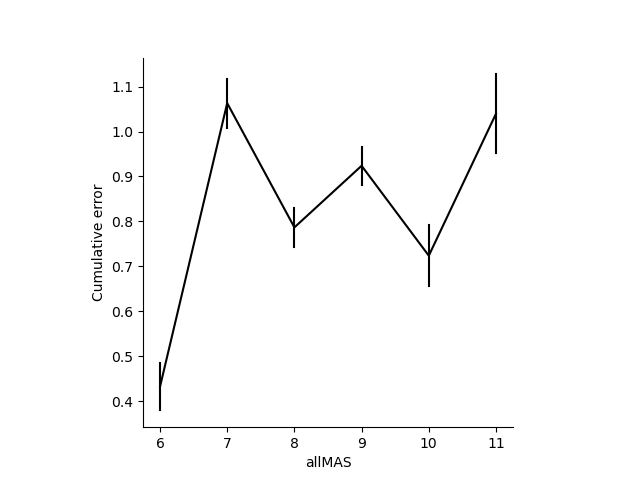

In [89]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='allMAS', y='cumulative_error', 
             data = error_sub,
             color = 'k',
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# axs.set_ylim(0,0.7)
axs.set(xlabel='allMAS', ylabel='Cumulative error')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'error_mas.png', dpi=300, bbox_inches='tight')
plt.show()

#### check total RT confound (supp)

In [110]:
TT_sub = state_df.groupby(['subjects','allMAS'])['TT'].mean().reset_index() # TT is from basic condition
TT_sub.groupby(['allMAS'])['TT'].count()

allMAS
6      99
7      99
8     100
9     100
10     99
11     99
Name: TT, dtype: int64

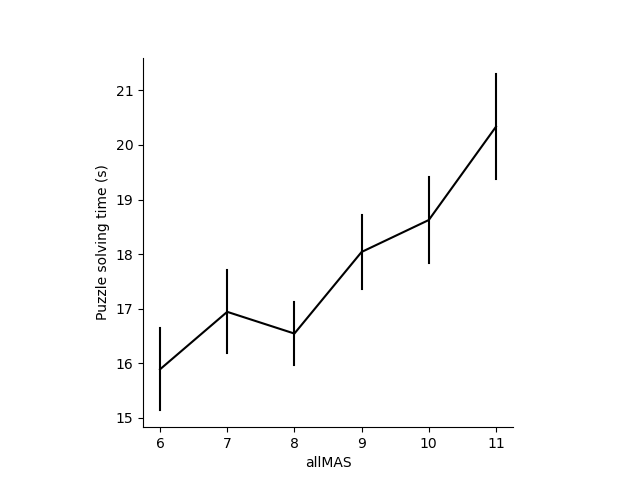

In [111]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='allMAS', y='TT', data = TT_sub, color = 'k',
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
axs.set(xlabel='allMAS', ylabel='Puzzle solving time (s)')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'TT_allMAS.png', dpi=300, bbox_inches='tight')

### Remaining budget

#### undo

In [112]:
firstUndo_sub = state_df.groupby(['subjects','leftover_bin', 'error'])['firstUndo'].mean().reset_index()
# count ignore nan
firstUndo_sub.groupby(['leftover_bin', 'error'])['firstUndo'].count()

leftover_bin  error
1             False     97
              True      95
2             False     98
              True      98
3             False     96
              True      99
4             False     95
              True      98
5             False     56
              True      97
6             False     31
              True      93
7             False      0
              True     100
Name: firstUndo, dtype: int64

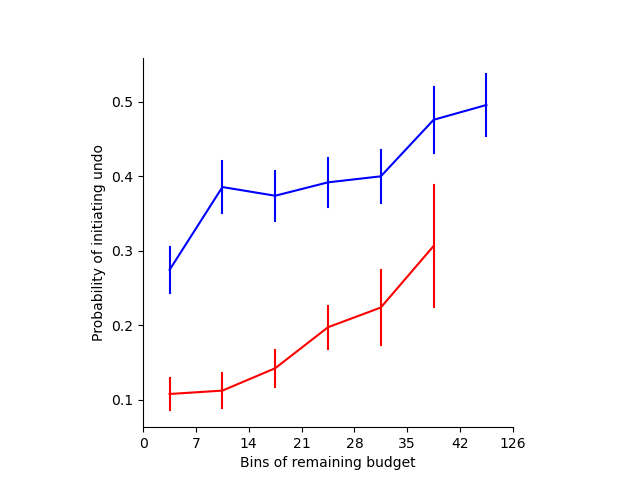

In [113]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='leftover_bin', y='firstUndo', 
             data = firstUndo_sub[firstUndo_sub.leftover_bin<=7],
             hue = 'error',
                palette = ['red','blue'],
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# use cutoff to set x ticklabels
axs.set_xticks(np.arange(0.5, 8.5, 1))
axs.set_xticklabels(cutoff)
# hide legend
axs.get_legend().remove()
# axs.set_ylim(0,0.6)
axs.set(xlabel='Bins of remaining budget', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_budget.png', dpi=300, bbox_inches='tight')
plt.show()

#### error

In [114]:
error_sub = state_df.groupby(['subjects','leftover_bin'])['cumulative_error'].mean().reset_index()
error_sub.groupby(['leftover_bin'])['cumulative_error'].count()

leftover_bin
1     99
2     99
3     99
4     99
5     99
6     93
7    100
Name: cumulative_error, dtype: int64

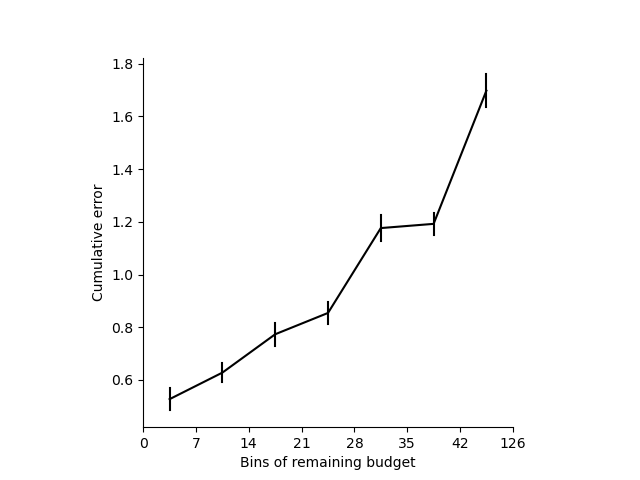

In [115]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='leftover_bin', y='cumulative_error', 
             data = error_sub,
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks(np.arange(0.5, 8.5, 1))
axs.set_xticklabels(cutoff)
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# axs.set_ylim(0,0.7)
axs.set(xlabel='Bins of remaining budget', ylabel='Cumulative error')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'error_leftover.png', dpi=300, bbox_inches='tight')
plt.show()

In [116]:
spearmanr(state_df['leftover'], state_df['currNumCities'])

SpearmanrResult(correlation=-0.17782586101454617, pvalue=1.1924383868962863e-46)

### statistics

In [14]:
# remove some columns
state_df_cp = state_df.drop(['leftover_bin', "budget_change_bin", "withinreach_change_bin"], axis=1)

In [15]:
%%R -i state_df_cp,out_dir2
state_df = state_df_cp
state_df$subjects <- as.factor(state_df[,"subjects"])
# state_df$TT_new <- state_df[,"TT"]^(0.5)
state_df$leftover_new <- state_df[,"leftover"]^(0.3)

model_undo = lme4::glmer(firstUndo ~  1 + currNumCities + leftover_new  + (1 |subjects) ,
                                  data = state_df, family = binomial(link="logit"))

save(model_undo, state_df, file=file.path(out_dir2, file=paste("model_undo_optimal_mas_budget.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + currNumCities + leftover_new + (1 | subjects)
   Data: state_df

     AIC      BIC   logLik deviance df.resid 
  5281.8   5308.8  -2636.9   5273.8     6400 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.7854 -0.4618 -0.1503  0.4002 20.3200 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 6.245    2.499   
Number of obs: 6404, groups:  subjects, 100

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)    1.71797    0.37888   4.534 5.78e-06 ***
currNumCities -0.81475    0.03264 -24.960  < 2e-16 ***
leftover_new   1.10528    0.06619  16.699  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) crrNmC
currNumCits -0.585       
leftover_nw -0.407 -0.041


In [ ]:
%%R -i state_df_cp,out_dir2

model_undo = lme4::glmer(firstUndo ~  1 + currNumCities + leftover_new  + (1 |subjects) ,
                                  data = state_df, family = binomial(link="logit"))

save(model_undo, state_df, file=file.path(out_dir2, file=paste("model_undo_optimal_mas_budget.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

### budget change

#### undo

In [112]:
firstUndo_sub = state_df.groupby(['subjects','budget_change_bin', 'error'])['firstUndo'].mean().reset_index()
# count ignore nan
firstUndo_sub.groupby(['budget_change_bin', 'error'])['firstUndo'].count()

budget_change_bin  error
1                  False     99
                   True      99
2                  False     98
                   True     100
3                  False     96
                   True      97
4                  False     88
                   True      90
5                  False     22
                   True      66
6                  False      0
                   True      84
7                  False      0
                   True      61
Name: firstUndo, dtype: int64

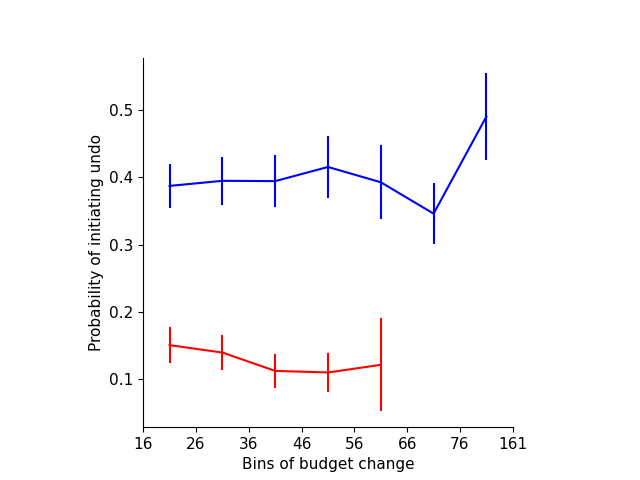

In [116]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='budget_change_bin', y='firstUndo', 
             data = firstUndo_sub,
             hue = 'error',
                palette = ['red','blue'],
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# use cutoff to set x ticklabels
axs.set_xticks(np.arange(0.5, 8.5, 1))
axs.set_xticklabels(cutoff)
# hide legend
axs.get_legend().remove()
# axs.set_ylim(0,0.6)
axs.set(xlabel='Bins of budget change', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_budgetchange_terminal.png', dpi=300, bbox_inches='tight')
plt.show()

#### error

In [124]:
error_sub = state_df.groupby(['subjects','budget_change_bin'])['severityOfErrors'].mean().reset_index()
error_sub.groupby(['budget_change_bin'])['severityOfErrors'].count()

budget_change_bin
1     99
2    100
3     98
4     99
5     73
6     84
7     61
Name: severityOfErrors, dtype: int64

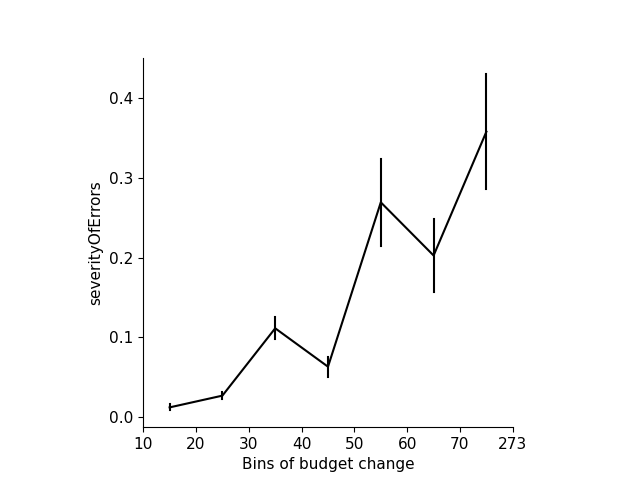

In [125]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='budget_change_bin', y='severityOfErrors', 
             data = error_sub,
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks(np.arange(0.5, 8.5, 1))
axs.set_xticklabels(cutoff)
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# axs.set_ylim(0,0.7)
axs.set(xlabel='Bins of budget change', ylabel='severityOfErrors')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'error_budgetchange_terminal.png', dpi=300, bbox_inches='tight')
plt.show()

### within reach

#### undo

In [148]:
# plot undo across leftover_bin
undo_error_sub = state_df.groupby(['subjects','withinreach_change_bin'])['firstUndo'].mean().reset_index()
undo_error_sub.groupby(['withinreach_change_bin'])['firstUndo'].count()


withinreach_change_bin
1    100
2    100
3     99
Name: firstUndo, dtype: int64

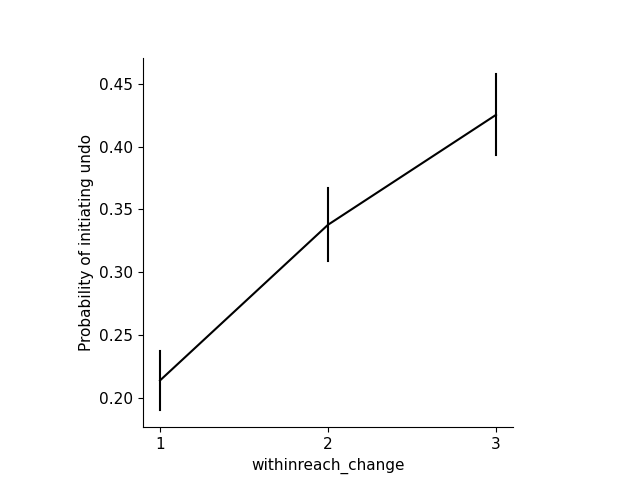

In [151]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='withinreach_change_bin', y='firstUndo', 
             data = undo_error_sub,
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks([1,2,3])
# axs.set_ylim(0,0.15)
axs.set(xlabel='withinreach_change', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_withinreach_change_terminal.png', dpi=300, bbox_inches='tight')

#### error

In [152]:
# plot undo across leftover_bin
undo_error_sub = state_df.groupby(['subjects','withinreach_change_bin'])['severityOfErrors'].mean().reset_index()
undo_error_sub.groupby(['withinreach_change_bin'])['severityOfErrors'].count()

withinreach_change_bin
1    100
2    100
3     99
Name: severityOfErrors, dtype: int64

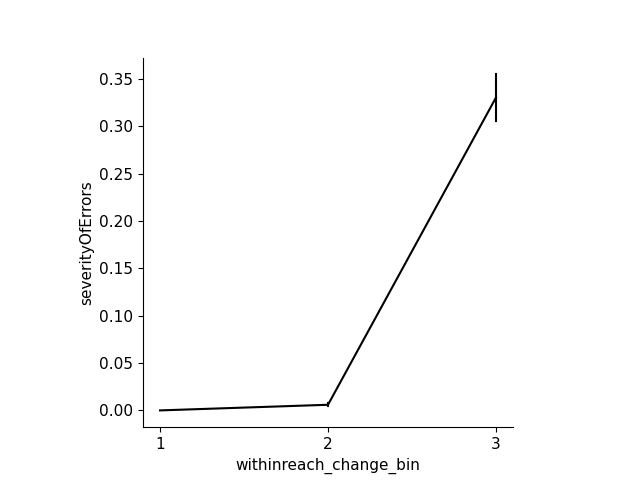

In [154]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='withinreach_change_bin', y='severityOfErrors', 
             data = undo_error_sub,
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks([1,2,3])
# axs.set_ylim(0,0.15)
axs.set(xlabel='withinreach_change_bin', ylabel='severityOfErrors')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'error_withinreachchange_terminal.png', dpi=300, bbox_inches='tight')

### Uncertainty (First-move RT)

In [204]:
# for RT1 and RT_branching, use only the very first undo
    
# before undo
index_first_undo = data_subset_before1undo.index[(data_subset_before1undo['firstUndo'] == 1)] # submit
df_beforeUndo = data_subset_before1undo.loc[index_first_undo-1,:]
index_end_undo = df_beforeUndo.index[(df_beforeUndo.checkEnd == 1)] # there are no errors and  end of trial
state_undo_1undo = df_beforeUndo.loc[index_end_undo, ['subjects','puzzleID',"cumulative_error"]]

subjects_undo = list(df_beforeUndo.loc[index_end_undo,'subjects'])
puzzleID_undo = list(df_beforeUndo.loc[index_end_undo,'puzzleID'])
RT1, RT_branching, RTsubmit = filter_dataframe(single_condition_data, subjects_undo, puzzleID_undo)
RT1_basic,_,_ = filter_dataframe(puzzleID_order_data[puzzleID_order_data['condition']==0], subjects_undo, puzzleID_undo)
state_undo_1undo["RT1"] = RT1
state_undo_1undo["undoRT"] = list(data_subset_before1undo.loc[index_end_undo+1,'undoRT'])
state_undo_1undo["RT1_basic"] = RT1_basic
state_undo_1undo["RTsubmit"] = RTsubmit
# take log of RT1 as a new column
state_undo_1undo["RT1_log"] = np.log(state_undo_1undo["RT1"]+1)
state_undo_1undo["RT1_basic_log"] = np.log(state_undo_1undo["RT1_basic"]+1)
state_undo_1undo["RT_branching"] = RT_branching
state_undo_1undo['firstUndo'] = 1

# before submit
index_notundo = data_subset_before1undo.index[(data_subset_before1undo['submit'] == 1)] # submit
df_notbeforeUndo = data_subset_before1undo.loc[index_notundo-1,:]
index_end_notundo = df_notbeforeUndo.index[(df_notbeforeUndo.checkEnd == 1)]
state_notundo_1undo = df_notbeforeUndo.loc[index_end_notundo,['subjects','puzzleID',"cumulative_error"]]

subjects = list(df_notbeforeUndo.loc[index_end_notundo,'subjects'])
puzzleID = list(df_notbeforeUndo.loc[index_end_notundo,'puzzleID'])
RT1, RT_branching, RTsubmit = filter_dataframe(single_condition_data, subjects, puzzleID)
RT1_basic,_,_ = filter_dataframe(puzzleID_order_data[puzzleID_order_data['condition']==0], subjects, puzzleID)
state_notundo_1undo["RT1"] = RT1
state_notundo_1undo["RT1_basic"] = RT1_basic
state_notundo_1undo["RT1_log"] = np.log(state_notundo_1undo["RT1"]+1)
state_notundo_1undo["RT1_basic_log"] = np.log(state_notundo_1undo["RT1_basic"]+1)
state_notundo_1undo["RT_branching"] = RT_branching 
state_notundo_1undo['firstUndo'] = 0
state_notundo_1undo['RTsubmit'] = RTsubmit#list(data_subset_before1undo.loc[index_end_notundo+1,'RT'])

state_df_1undo = pd.concat([state_undo_1undo,state_notundo_1undo])
temp1, cutoff = pd.cut(state_df_1undo['RT1_log'], bins=5, labels=range(1,6),retbins=True)
state_df_1undo['rt1_bin'] = temp1
state_df_1undo['rt1_bin'] = state_df_1undo['rt1_bin'].astype(int)
state_df_1undo = state_df_1undo.reset_index(drop=True)
max(state_df_1undo['rt1_bin'])
state_df_1undo['error'] = state_df_1undo['cumulative_error'] > 0

##### undo 

In [205]:
firstUndo_sub = state_df_1undo.groupby(['subjects','rt1_bin',"error"])['firstUndo'].mean().reset_index()
firstUndo_sub.groupby(['rt1_bin',"error"])['firstUndo'].count()

rt1_bin  error
1        False    92
         True     92
2        False    97
         True     99
3        False    54
         True     66
4        False     8
         True     16
5        False     1
         True      4
Name: firstUndo, dtype: int64

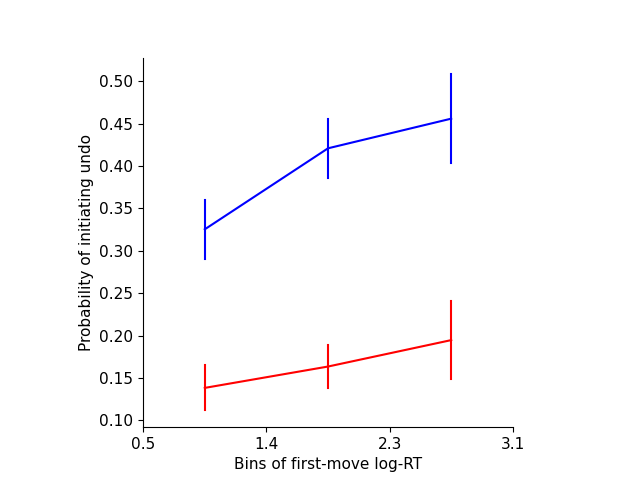

In [209]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='rt1_bin', y='firstUndo', 
             data = firstUndo_sub[firstUndo_sub.rt1_bin<=3],
             hue = "error",
                palette = ['red','blue'],
             err_style = "bars",
             errorbar = "se")
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# use cutoff to set x ticklabels
#axs.set_xticks(np.arange(0.5, 7.5, 1))
# only use 1 decimal place
cutoff_round = [round(i,1) for i in cutoff]
axs.set_xticks(np.arange(0.5, 4.5, 1))
axs.set_xticklabels(cutoff_round[:-2])
# hide legend
axs.get_legend().remove()
# axs.set_ylim([0,0.2])
# axs.set_yticks(np.arange(0, 0.25, 0.05))
axs.set(xlabel='Bins of first-move log-RT', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'undo_first_rt.png', dpi=300, bbox_inches='tight')
plt.show()

##### error 

In [207]:
error_sub = state_df_1undo.groupby(['subjects','rt1_bin'])['cumulative_error'].mean().reset_index()
error_sub.groupby(['rt1_bin'])['cumulative_error'].count()

rt1_bin
1    98
2    99
3    74
4    22
5     4
Name: cumulative_error, dtype: int64

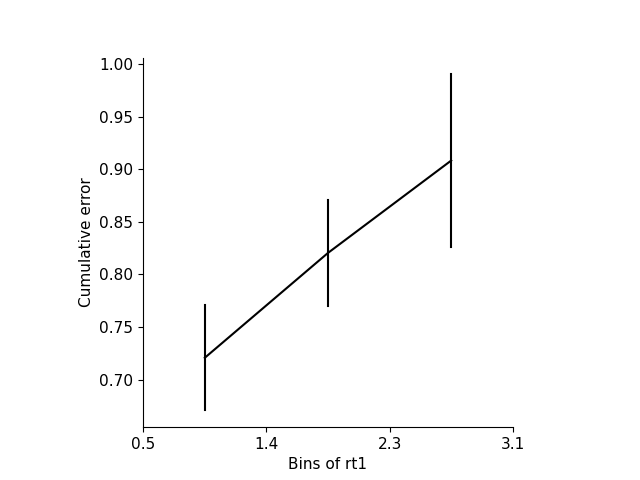

In [208]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot    
sns.lineplot(x='rt1_bin', y='cumulative_error', 
             data = error_sub[error_sub.rt1_bin<=3],
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks(np.arange(0.5, 4.5, 1))
axs.set_xticklabels(cutoff_round[:-2])
#sns.lineplot(x='severityOfErrors', y='sequentialUndo', data = sequentialUndo_sub, errorbar = "se")
# axs.set_ylim(0,0.7)
axs.set(xlabel='Bins of rt1', ylabel='Cumulative error')
axs.set_aspect(1/axs.get_data_ratio())
fig.savefig(out_dir+'error_rt.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
%%R -i state_df_1undo,out_dir2
state_df_1undo$subjects <- as.factor(state_df_1undo[,"subjects"])

model_undo = lme4::glmer(firstUndo ~  1 + RT1_log + (1 |subjects) + (1 |puzzleID),
                                  data = state_df_1undo, family = binomial(link="logit"))

# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + RT1_log + (1 | subjects) + (1 | puzzleID)
   Data: state_df_1undo

     AIC      BIC   logLik deviance df.resid 
  1080.1   1102.2   -536.1   1072.1     1842 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7849 -0.2659 -0.1166 -0.0472  6.9214 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 8.401    2.898   
 puzzleID (Intercept) 2.011    1.418   
Number of obs: 1846, groups:  subjects, 99; puzzleID, 45

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.5888     0.5844  -7.853 4.07e-15 ***
RT1_log       0.4237     0.2155   1.967   0.0492 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
RT1_log -0.598


In [ ]:
%%R -i state_df_1undo,out_dir2
state_df_1undo$subjects <- as.factor(state_df_1undo[,"subjects"])

model_undo = lme4::glmer(firstUndo ~  1 + RT1_basic_log + (1 |subjects) + (1 |puzzleID),
                                  data = state_df_1undo, family = binomial(link="logit"))

# save(model_undo, state_df_1undo, file=file.path(out_dir2, file=paste("model_undo_rt1.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: firstUndo ~ 1 + RT1_basic_log + (1 | subjects) + (1 | puzzleID)
   Data: state_df_1undo

     AIC      BIC   logLik deviance df.resid 
  1083.3   1105.4   -537.7   1075.3     1842 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3203 -0.2645 -0.1171 -0.0473  6.5258 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 8.461    2.909   
 puzzleID (Intercept) 2.057    1.434   
Number of obs: 1846, groups:  subjects, 99; puzzleID, 45

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -4.1847     0.5728  -7.305 2.77e-13 ***
RT1_basic_log   0.1570     0.1968   0.798    0.425    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
RT1_basc_lg -0.570


#### correlation with undoRT/submitRT

In [149]:
print(spearmanr(state_undo_1undo.groupby(['subjects'])['RT1'].mean() , state_undo_1undo.groupby(['subjects'])['undoRT'].mean()))

SpearmanrResult(correlation=0.39315581654348486, pvalue=0.00021603234339970947)


In [150]:
print(spearmanr(state_undo_1undo.groupby(['subjects'])['RT1'].mean() , state_undo_1undo.groupby(['subjects'])['RTsubmit'].mean()))

SpearmanrResult(correlation=0.3579021970233877, pvalue=0.0008301893408130178)


In [151]:
print(spearmanr(state_notundo_1undo.groupby(['subjects'])['RT1'].mean() , state_notundo_1undo.groupby(['subjects'])['RTsubmit'].mean()))

SpearmanrResult(correlation=0.5707948996201845, pvalue=1.2638417618044503e-09)


## Possible cues for error correction - nonterminal

In [137]:
# index before undo/not undo, but the possibility of undo cannot be 0
index_undo = sc_data_choice_level.index[(sc_data_choice_level['submit']!=1)&(sc_data_choice_level['currNumCities']!=0)&(sc_data_choice_level['undo']==0)]
undo_error = sc_data_choice_level.loc[index_undo+1, ["subjects","undo",'firstUndo','lastUndo']]
# add sc_data_choice_level.loc[index_undo, "severityOfErrors"] as a list column to undo_error
undo_error['severityOfErrors'] = sc_data_choice_level.loc[index_undo, "severityOfErrors"].values
undo_error['cumulative_error'] = sc_data_choice_level.loc[index_undo, "cumulative_error"].values
undo_error['checkEnd'] = sc_data_choice_level.loc[index_undo, "checkEnd"].values
undo_error['leftover'] = sc_data_choice_level.loc[index_undo, "leftover"].values
undo_error['budget_change'] = abs(sc_data_choice_level.loc[index_undo, "budget_change"].values)
undo_error['withinreach_change'] = abs(sc_data_choice_level.loc[index_undo, "within_reach_change"].values)

undo_error = undo_error[undo_error['checkEnd']==0]

# Binning 'leftover' into bins
temp,cutoff = pd.cut(undo_error['budget_change'], bins=[10, 20, 30, 40, 50, 60, 70, 273], labels=range(1, 8), retbins=True)
undo_error['budget_change_bin'] = temp
temp,cutoff = pd.cut(undo_error['withinreach_change'], bins=[1,2,3,4,5,10,15,26], labels=range(1, 8), retbins=True)
undo_error['withinreach_change_bin'] = temp

In [136]:
undo_error['withinreach_change'].describe()

count    40820.000000
mean         3.928638
std          3.033951
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         25.000000
Name: withinreach_change, dtype: float64

### budget change

#### undo

In [120]:
# plot undo across leftover_bin
undo_error_sub = undo_error.groupby(['subjects','budget_change_bin'])['undo'].mean().reset_index()
undo_error_sub.groupby(['budget_change_bin'])['undo'].count()


budget_change_bin
1    100
2    100
3    100
4    100
5    100
6    100
7    100
Name: undo, dtype: int64

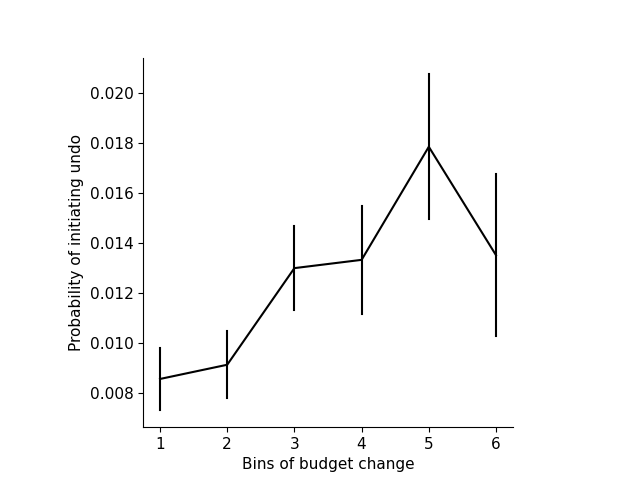

In [121]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='budget_change_bin', y='undo', 
             data = undo_error_sub[undo_error_sub.budget_change_bin<=6],
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks([1,2,3,4,5,6])
# axs.set_ylim(0,0.15)
axs.set(xlabel='Bins of budget change', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_budgetchange_nonterminal.png', dpi=300, bbox_inches='tight')

#### error

In [122]:
# plot undo across leftover_bin
undo_error_sub = undo_error.groupby(['subjects','budget_change_bin'])['severityOfErrors'].mean().reset_index()
undo_error_sub.groupby(['budget_change_bin'])['severityOfErrors'].count()

budget_change_bin
1    100
2    100
3    100
4    100
5    100
6    100
7    100
Name: severityOfErrors, dtype: int64

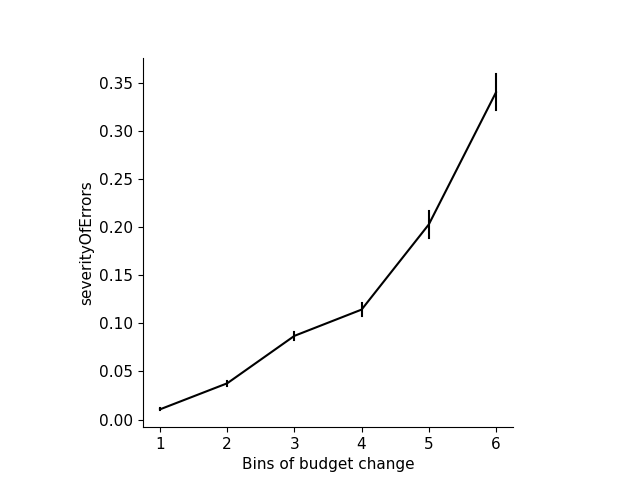

In [123]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='budget_change_bin', y='severityOfErrors', 
             data = undo_error_sub[undo_error_sub.budget_change_bin<=6],
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks([1,2,3,4,5,6])
# axs.set_ylim(0,0.15)
axs.set(xlabel='Bins of budget change', ylabel='severityOfErrors')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'error_budgetchange_nonterminal.png', dpi=300, bbox_inches='tight')

### within reach

#### undo

In [138]:
# plot undo across leftover_bin
undo_error_sub = undo_error.groupby(['subjects','withinreach_change_bin'])['undo'].mean().reset_index()
undo_error_sub.groupby(['withinreach_change_bin'])['undo'].count()


withinreach_change_bin
1    100
2    100
3    100
4    100
5    100
6    100
7     86
Name: undo, dtype: int64

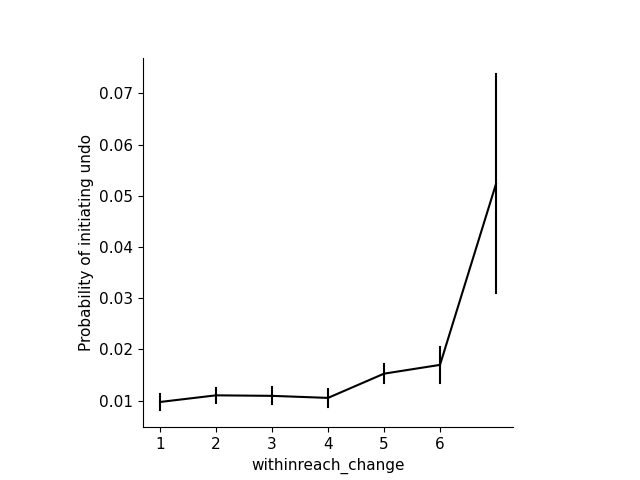

In [139]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='withinreach_change_bin', y='undo', 
             data = undo_error_sub,
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks([1,2,3,4,5,6])
# axs.set_ylim(0,0.15)
axs.set(xlabel='withinreach_change', ylabel='Probability of initiating undo')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_withinreach_change_nonterminal.png', dpi=300, bbox_inches='tight')

#### error

In [140]:
# plot undo across leftover_bin
undo_error_sub = undo_error.groupby(['subjects','withinreach_change_bin'])['severityOfErrors'].mean().reset_index()
undo_error_sub.groupby(['withinreach_change_bin'])['severityOfErrors'].count()

withinreach_change_bin
1    100
2    100
3    100
4    100
5    100
6    100
7     86
Name: severityOfErrors, dtype: int64

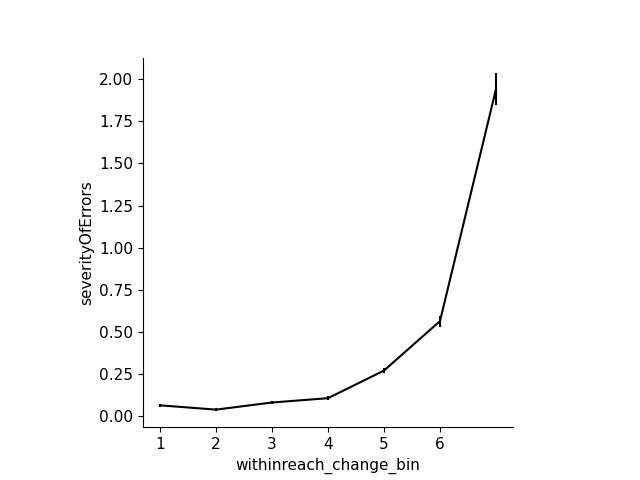

In [141]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='withinreach_change_bin', y='severityOfErrors', 
             data = undo_error_sub,
             color = 'k',
             err_style = "bars",
             errorbar = "se")
axs.set_xticks([1,2,3,4,5,6])
# axs.set_ylim(0,0.15)
axs.set(xlabel='withinreach_change_bin', ylabel='severityOfErrors')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'error_withinreachchange_nonterminal.png', dpi=300, bbox_inches='tight')

## RT

### across moves

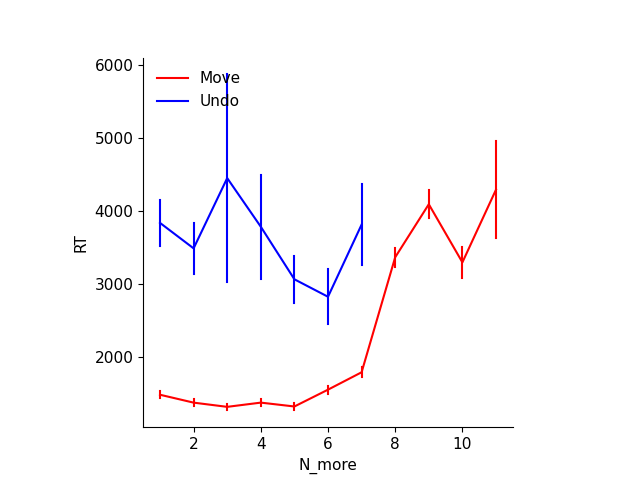

In [181]:
def organize_data(df, cond, type_):
    index_singleUndo = df.index[cond]
    df1 = df.loc[index_singleUndo, ['subjects', 'RT', 'undo']]
    df1["N_more"] = df.loc[index_singleUndo-1, 'N_more'].values
    df1 = df1[df1.N_more!=0]
    df1['type'] = type_
    return df1

data_subset_before1undo['N_more'] = data_subset_before1undo["currMas"] - data_subset_before1undo["currNumCities"]
df1 = organize_data(data_subset_before1undo, (data_subset_before1undo['firstUndo'] == 1) &(data_subset_before1undo['lastUndo'] == 1), "singleUndo")
df2 = organize_data(data_subset_before1undo, (data_subset_before1undo['firstUndo'] == 1) &(data_subset_before1undo['lastUndo'] != 1), "seqUndo")
df3 = organize_data(data_subset_before1undo, (data_subset_before1undo['undo'] == 0) & (data_subset_before1undo['RT'] != -1), "move")

df_all = pd.concat([df1, df2, df3])
df = df_all.groupby(["undo",'subjects','N_more'])['RT'].mean().reset_index()
count_df = df.groupby(["undo",'N_more'])['RT'].count().reset_index()
df = df.merge(count_df, on = ["undo",'N_more'], how = "left", suffixes = ("","_count"))
df = df[df['RT_count'] > 20]

%matplotlib widget
fig, axs = plt.subplots(1, 1)
sns.lineplot(x='N_more', y='RT', 
             data = df,
             err_style = "bars",
             errorbar = "se",
             hue = 'undo',
             palette = ['red','blue'])

plt.legend(labels=['Move','Undo'], loc='upper left')
axs.set(xlabel='N_more', ylabel='RT')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'RT_Nmore.png', dpi=300, bbox_inches='tight')

### sequential undo and single undo

In [11]:
def get_undoRT(index):
    RT = data_choice_level.loc[index,:]
    RT_sub = RT.groupby(['subjects'])['undoRT'].mean()/1000
    RT_sub_sem = sem(RT_sub)
    return [RT_sub,RT_sub_sem]

index_singleUndo = data_choice_level.index[(data_choice_level['firstUndo'] == 1)&(data_choice_level['lastUndo'] == 1)]
RT_singleUndo = get_undoRT(index_singleUndo)

index_firstUndo = data_choice_level.index[(data_choice_level['firstUndo'] == 1) &(data_choice_level['lastUndo'] != 1)]
RT_firstUndo = get_undoRT(index_firstUndo)

index_laterUndo = data_choice_level.index[(data_choice_level['firstUndo'] != 1) & (data_choice_level['undo'] == 1)]
RT_laterUndo = get_undoRT(index_laterUndo)

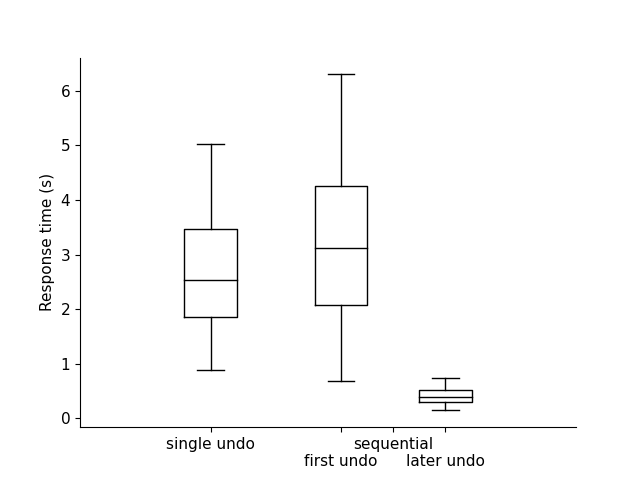

In [42]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)

bx = axs.boxplot(
    [
        RT_singleUndo[0],
        RT_firstUndo[0],
        RT_laterUndo[0]
    ],
    positions =[0.5,1,1.4],
    widths = 0.2,
    showfliers=False,
    whis = 1,
   medianprops = dict(color = 'k'))  #

axs.set_xticks([0.5,1,1.2,1.4])
axs.set_xticklabels(labels = ['single undo','\nfirst undo','sequential','\nlater undo'])#,fontsize=18
axs.set_ylabel('Response time (s)') #,fontsize=18
plt.show()
fig.savefig(out_dir + 'undo_RT.png', dpi=600, bbox_inches='tight')

In [261]:
#--------------------------------------
# run 2-independent-sample t test
stat1, p1 = wilcoxon(np.log(1+RT_firstUndo[0]),np.log(1+RT_laterUndo[0]))
x1, x2 = 1,1.4
y, h, col = bx['caps'][3]._y[0] + 0.5, 0.1, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
text(p1)

#--------------------------------------
stat3, p3 = mannwhitneyu(np.log(1+RT_firstUndo[0]),np.log(1+RT_singleUndo[0]))
print(stat3, p3 )
x1, x2 = 0.5,1
y, h, col = bx['caps'][3]._y[0] + 0.5, 0.1, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
text(p3)
fig.savefig(out_dir + 'undo_RT.png', dpi=600, bbox_inches='tight')

4000.0 0.01593829273028334


### undo or submit from terminal state

#### all

In [55]:
def get_lastRT(index):
    RT = state_df.loc[index,:]
    RT_sub = RT.groupby(['subjects'])['lastRT'].mean()/1000
    RT_sub_sem = sem(RT_sub)
    return [RT_sub,RT_sub_sem]

index_undo = state_df.index[(state_df['firstUndo'] == 1)]
RT_undo = get_lastRT(index_undo)

index_submit = state_df.index[(state_df['firstUndo'] == 0)]
RT_submit = get_lastRT(index_submit)

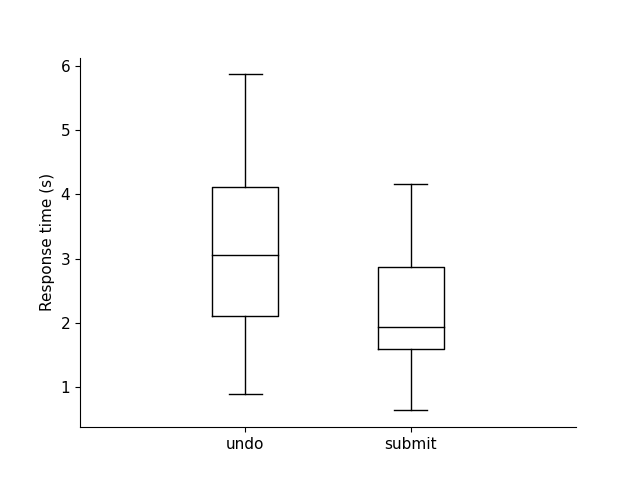

In [63]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)

bx = axs.boxplot(
    [
        RT_undo[0],
        RT_submit[0]
    ],
    positions =[0.5,1],
    widths = 0.2,
    showfliers=False,
    whis = 1,
   medianprops = dict(color = 'k'))  #

axs.set_xticks([0.5,1])
axs.set_xticklabels(labels = ['undo','submit'])#,fontsize=18
axs.set_ylabel('Response time (s)') #,fontsize=18
plt.show()
fig.savefig(out_dir + 'undosubmit_RT.png', dpi=600, bbox_inches='tight')

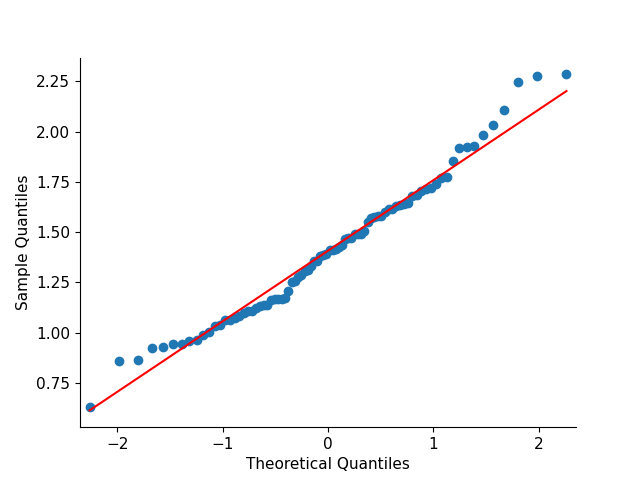

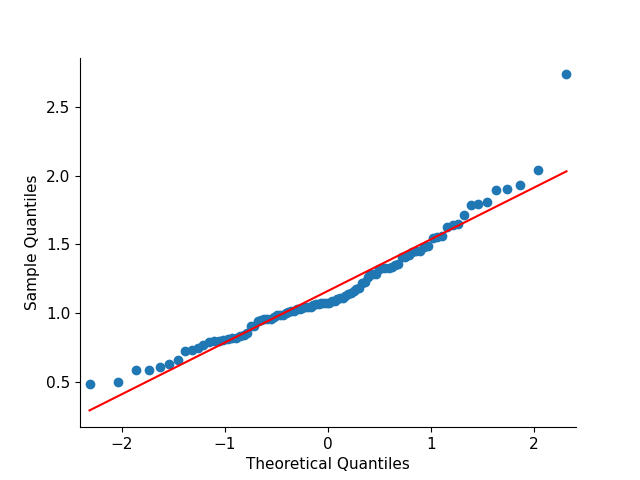

84
96


In [64]:
## check normality
sm.qqplot(np.log(1+RT_undo[0]), line='s')
py.show()
sm.qqplot(np.log(1+RT_submit[0]), line='s')
py.show()


print(len(np.log(1+RT_undo[0])))
print(len(np.log(1+RT_submit[0])))

In [65]:
#--------------------------------------
# run 2-independent-sample t test
stat1, p1 = ttest_ind(np.log(1+RT_undo[0]),np.log(1+RT_submit[0]), equal_var = False)
x1, x2 = 0.5,1
y, h, col = bx['caps'][1]._y[0] + 0.5, 0.1, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
text(p1)

fig.savefig(out_dir + 'undosubmit_RT.png', dpi=600, bbox_inches='tight')

#### different currNumcities

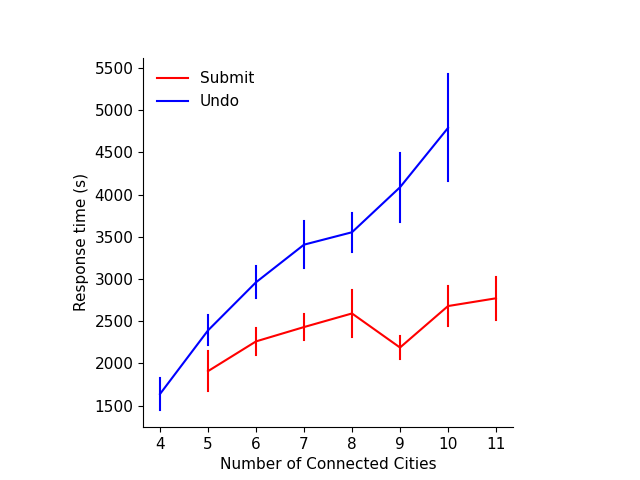

In [172]:
plot_df = state_df.groupby(['subjects','firstUndo','currNumCities'])['lastRT'].mean().reset_index()
count_df = plot_df.groupby(['firstUndo','currNumCities'])['lastRT'].count()
plot_df = plot_df.merge(count_df, on = ['firstUndo','currNumCities'], how = "left", suffixes = ("","_count"))
plot_df = plot_df[plot_df['lastRT_count'] > 20]

# plot 
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='currNumCities', y='lastRT', 
             data = plot_df,
             hue = 'firstUndo',
             palette = ['red','blue'],
             err_style = "bars",
             errorbar = "se")
# add manual legend
plt.legend(labels=['Submit','Undo'], loc='upper left')
axs.set(xlabel='Number of Connected Cities', ylabel='Response time (s)')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undosubmit_RT_currNumCities.png', dpi=300, bbox_inches='tight')

# Undo completion

## Error before and after undo

In [243]:
mas_gain_df = pd.DataFrame(columns = ['subjects','puzzleID','cum_error_beginning','cum_error_end','error_beginning','error_rate_beginning','error_rate_end','mas_gain'])

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index_copy"]) # here the index is original index in data_choice_level    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
        error_rate_beginning_list = []
    
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        
        # all last undo
        lastUndo_idx = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)].index 
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1
            # get cumulative error at undo beginning
            cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
            cum_error_beginning_list.append(cum_error_beginning)
            error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
            error_beginning_list.append(error_beginning)
            error_rate_beginning = dat_sbj_pzi.loc[x-j-1,"error_rate"]
            error_rate_beginning_list.append(error_rate_beginning)

        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])
        error_rate_end = list(df_undoTarget['error_rate'])
        # use each value in cum_error_beginning_list to subtract accu_severity_error
        mas_gain = []
        cum_error_end_list = []
        error_rate_end_list = []
        for i in range(len(cum_error_beginning_list)):
            mas_gain.append(cum_error_beginning_list[i] - accu_severity_error[i])
            cum_error_end_list.append(accu_severity_error[i])
            error_rate_end_list.append(error_rate_end[i])
        
        
        # if category is not empty, add it to an empty dataframe
        if len(mas_gain) > 0:
            mas_gain_df = pd.concat([mas_gain_df,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                               'cum_error_beginning':cum_error_beginning_list, 'cum_error_end':cum_error_end_list,
                                                               'error_beginning':error_beginning_list, 
                                                               'error_rate_beginning':error_rate_beginning_list,
                                                               'error_rate_end':error_rate_end_list,
                                                               'mas_gain':mas_gain})])


### Scatter plot

In [232]:
# scatter plot of cum_error_beginning and cum_error_end in mas_gain_df  
error_df_sub = mas_gain_df.groupby(['subjects'])['cum_error_beginning','cum_error_end'].mean().reset_index()

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_59698/948503816.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_df_sub = mas_gain_df.groupby(['subjects'])['cum_error_beginning','cum_error_end'].mean().reset_index()


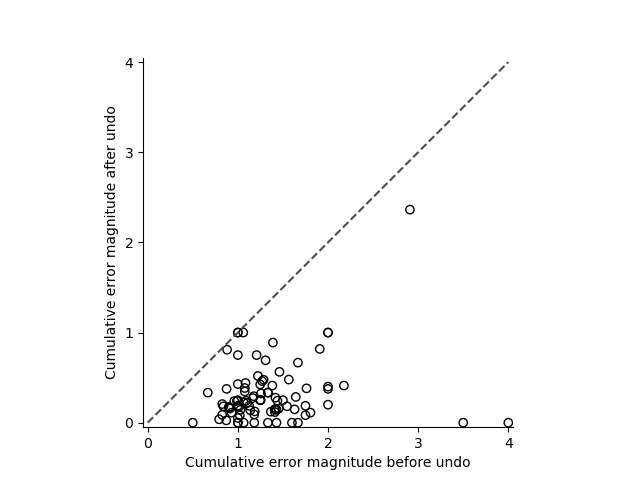

In [ ]:
%matplotlib widget
fig1, ax1 = plt.subplots()

sns.scatterplot(x='cum_error_beginning', y='cum_error_end', 
                            # use white fill
                edgecolor="black",
                facecolor="None",
                linewidth=1,
                data=error_df_sub) 
# add diagonal line
ax1.plot([0, 4], [0, 4], ls="--", c=".3")
ax1.set_xlim([-0.05,4.05])
ax1.set_ylim([-0.05,4.05])
ax1.set_xticks(np.arange(0, 4.5, 1))
ax1.set_yticks(np.arange(0, 4.5, 1))
ax1.set_xlabel("Cumulative error magnitude before undo")
ax1.set_ylabel("Cumulative error magnitude after undo")
ax1.set_aspect(1/ax1.get_data_ratio())
fig1.savefig(out_dir+'error_before_after_undo.png', dpi=300, bbox_inches='tight')
plt.show()

0.5286900147100068
0.34279494095060203


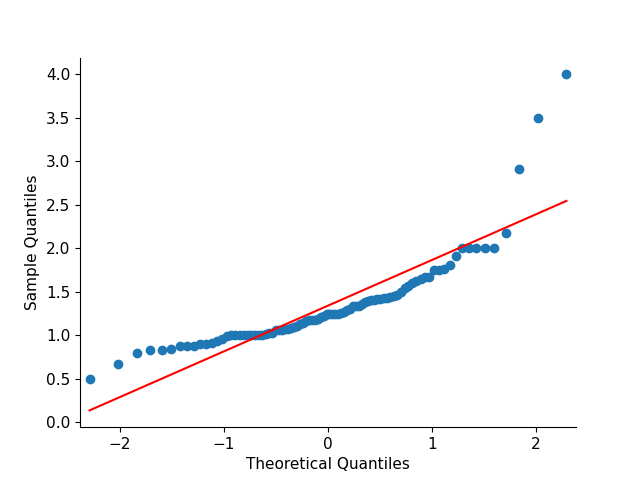

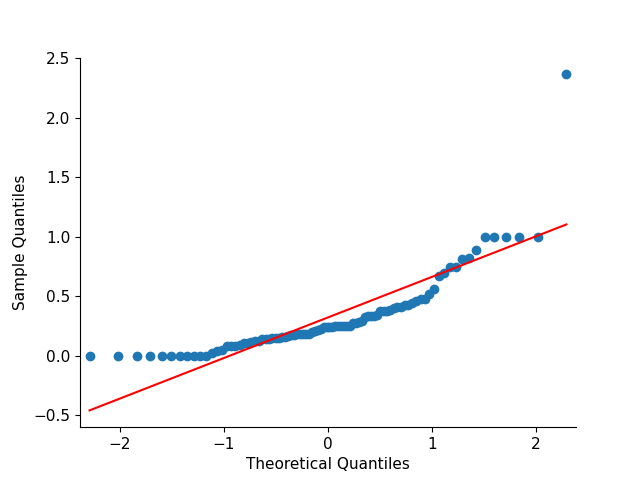

WilcoxonResult(statistic=3916.0, pvalue=1.8266971276429214e-16)


In [233]:
cum_error_before = mas_gain_df.groupby(['subjects'])['cum_error_beginning'].mean()
cum_error_after = mas_gain_df.groupby(['subjects'])['cum_error_end'].mean()

# check equal variance ----
print(np.std(cum_error_before, ddof=1))
print(np.std(cum_error_after, ddof=1))

# check normality ----
sm.qqplot(cum_error_before, line='s')
py.show()
sm.qqplot(cum_error_after, line='s')
py.show()

print(wilcoxon(cum_error_before, cum_error_after, alternative = 'greater'))


### Error rate

In [ ]:
# scatter plot of cum_error_beginning and cum_error_end in mas_gain_df  
error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()
error_df_sub

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_36892/3460544585.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()


,subjects,error_rate_beginning,error_rate_end
0,0,0.171176,0.015152
1,1,0.252847,0.113872
2,2,0.299482,0.055556
3,3,0.547619,0.000000
4,4,0.266478,0.084921
...,...,...,...
85,94,0.800000,0.000000
86,95,0.144901,0.091991
87,96,0.120201,0.011792
88,97,0.436508,0.166667


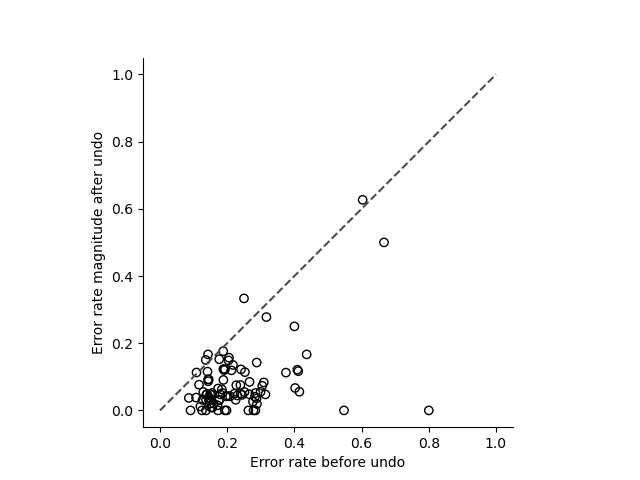

In [ ]:
%matplotlib widget
fig1, ax1 = plt.subplots()

sns.scatterplot(x='error_rate_beginning', y='error_rate_end', 
                            # use white fill
                edgecolor="black",
                facecolor="None",
                linewidth=1,
                data=error_df_sub) 
# add diagonal line
ax1.plot([0, 1], [0, 1], ls="--", c=".3")
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
# ax1.set_xticks(np.arange(0, 1.5, 1))
# ax1.set_yticks(np.arange(0, 1.5, 1))
ax1.set_xlabel("Error rate before undo")
ax1.set_ylabel("Error rate magnitude after undo")
ax1.set_aspect(1/ax1.get_data_ratio())
fig1.savefig(out_dir+'errorrate_before_after_undo.png', dpi=300, bbox_inches='tight')
plt.show()

## Proportion of different undo result

In [250]:
accu_error_3 = pd.DataFrame(columns = ['subjects','puzzleID','terminal_beginning','cum_error_beginning','error_beginning','error_rate_beginning','category'])

for sub in range(100):
    dat_sbj  = sc_data_choice_level[sc_data_choice_level['subjects']==sub].sort_values(["puzzleID","index_copy"]) # here the index is original index in data_choice_level    
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
        error_rate_beginning_list = []
        terminal_beginning_list = []
    
        dat_sbj_pzi = dat_sbj[dat_sbj['puzzleID'] == pzi].reset_index()        

        # last undo index when it is not the start city
        lastUndo_idx_nostart = dat_sbj_pzi[(dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]!=0)].index 
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx_nostart:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1

            if dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"] == 0: # the state before first undo
                lastUndo_idx_nostart = lastUndo_idx_nostart.drop(x)
            else: 
                # get cumulative error at undo beginning
                cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
                cum_error_beginning_list.append(cum_error_beginning)
                error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
                error_beginning_list.append(error_beginning)
                error_rate_beginning = dat_sbj_pzi.loc[x-j-1,"error_rate"]
                error_rate_beginning_list.append(error_rate_beginning)
                terminal_beginning = dat_sbj_pzi.loc[x-j-1,"checkEnd"]
                terminal_beginning_list.append(terminal_beginning)

        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx_nostart,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])

        # cumulative error at the state before undo terminal
        df_undoTarget_before = dat_sbj_pzi.loc[lastUndo_idx_nostart-1,:]
        accu_severity_error_before = list(df_undoTarget_before['allMAS'] - df_undoTarget_before['currMas'])
        
        sequential_single = (dat_sbj_pzi.loc[lastUndo_idx_nostart,"firstUndo"] == 1)&(dat_sbj_pzi.loc[lastUndo_idx_nostart,"lastUndo"] == 1)
        category = [np.nan]*len(accu_severity_error) # the number of undo terminal
        
        for i in range(len(accu_severity_error)): 
            if accu_severity_error_before[i]==0: # undo too much
                category[i] = 0
            elif (accu_severity_error[i]==0)&(accu_severity_error_before[i]>0): # undo exactly the right amount
                category[i] = 1
            elif accu_severity_error[i] > 0: # undo too little
                category[i] = 2
        
        # if category is not empty, add it to an empty dataframe
        if len(category) > 0:
            accu_error_3 = pd.concat([accu_error_3,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                                 'cum_error_beginning':cum_error_beginning_list,'error_beginning':error_beginning_list,
                                                                    'error_rate_beginning':error_rate_beginning_list, 
                                                                    'sequential_single':sequential_single,
                                                                    'terminal_beginning':terminal_beginning_list,
                                                                 'category':category})])

accu_error_3["terminal"] = "notstart"

In [251]:
# create empty dataframe
accu_error_2 = pd.DataFrame(columns = ['subjects','puzzleID', 'terminal_beginning', 'cum_error_beginning','error_beginning','error_rate_beginning','category'])

for sub in range(100):
    dat_sbj  = sc_data_choice_level.loc[(sc_data_choice_level['subjects']==sub),:].sort_values(["puzzleID","index_copy"])
    for pzi in np.unique(sc_data_choice_level['puzzleID']):
        
        cum_error_beginning_list = []
        error_beginning_list = []
        error_rate_beginning_list = []
        terminal_beginning_list = []

        dat_sbj_pzi = dat_sbj.loc[(dat_sbj['puzzleID'] == pzi),:].reset_index()    

        # last undo index when it is not the start city
        # only select rows when (dat_sbj_pzi["lastUndo"]==1)&(dat_sbj_pzi["choice"]==0)
        lastUndo_idx_start = dat_sbj_pzi[(dat_sbj_pzi.lastUndo==1)&(dat_sbj_pzi.choice==0)].index
        # exclude the case when there is no error from the beginning
        for x in lastUndo_idx_start:
            j = 0
            while dat_sbj_pzi.loc[x-j,"firstUndo"] == 0:
                j = j + 1
            
            if dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"] == 0:
                lastUndo_idx_start = lastUndo_idx_start.drop(x)
            else: 
                # get cumulative error at undo beginning
                cum_error_beginning = dat_sbj_pzi.loc[x-j-1,"allMAS"] - dat_sbj_pzi.loc[x-j-1,"currMas"]
                cum_error_beginning_list.append(cum_error_beginning)
                error_beginning = dat_sbj_pzi.loc[x-j-1,"severityOfErrors"]
                error_beginning_list.append(error_beginning)
                error_rate_beginning = dat_sbj_pzi.loc[x-j-1,"error_rate"]
                error_rate_beginning_list.append(error_rate_beginning)
                terminal_beginning = dat_sbj_pzi.loc[x-j-1,"checkEnd"]
                terminal_beginning_list.append(terminal_beginning)
                
        # cumulative error at undo terminal
        df_undoTarget = dat_sbj_pzi.loc[lastUndo_idx_start,:]
        accu_severity_error = list(df_undoTarget['allMAS'] - df_undoTarget['currMas'])
        # cumulative error at the state before undo terminal
        df_undoTarget_before = dat_sbj_pzi.loc[lastUndo_idx_start-1,:]
        accu_severity_error_before = list(df_undoTarget_before['allMAS'] - df_undoTarget_before['currMas'])
        
        sequential_single = (dat_sbj_pzi.loc[lastUndo_idx_start,"firstUndo"] == 1)&(dat_sbj_pzi.loc[lastUndo_idx_start,"lastUndo"] == 1)
        category = [np.nan]*len(accu_severity_error)
        
        for i in range(len(accu_severity_error)): 
            if accu_severity_error_before[i]==0: # undo too much
                category[i] = 0
            elif (accu_severity_error[i]==0)&(accu_severity_error_before[i]>0): # undo exactly the right amount
                category[i] = 1

        # if category is not empty, add it to an empty dataframe
        if len(category) > 0:
            accu_error_2 = pd.concat([accu_error_2,pd.DataFrame({'subjects':sub,'puzzleID':pzi,
                                                                 'cum_error_beginning':cum_error_beginning_list,'error_beginning':error_beginning_list,
                                                                    'error_rate_beginning':error_rate_beginning_list,
                                                                    'sequential_single':sequential_single,
                                                                    'terminal_beginning':terminal_beginning_list,
                                                                 'category':category})])

accu_error_2["terminal"] = "start"

In [252]:
# combine accu_error_2 and accu_error_3 into one dataframe
accu_error = pd.concat([accu_error_2,accu_error_3])
# calcualte the proportion of each category plus terminal, grouped by subjects
accu_error_p = accu_error.groupby(['category','terminal','subjects']).size().unstack(fill_value=0).apply(lambda x: x/x.sum())
accu_error_p = accu_error_p.T
accu_error_p

category         0                   1                   2
terminal  notstart     start  notstart     start  notstart
subjects                                                  
0         0.222222  0.111111  0.555556  0.000000  0.111111
1         0.043478  0.000000  0.347826  0.173913  0.434783
2         0.033333  0.300000  0.066667  0.533333  0.066667
3         0.000000  0.500000  0.000000  0.500000  0.000000
4         0.000000  0.105263  0.105263  0.473684  0.315789
...            ...       ...       ...       ...       ...
94        0.000000  0.000000  0.000000  1.000000  0.000000
95        0.125000  0.083333  0.166667  0.333333  0.291667
96        0.142857  0.114286  0.257143  0.428571  0.057143
97        0.000000  0.000000  0.333333  0.333333  0.333333
99        0.227273  0.181818  0.045455  0.409091  0.136364

[90 rows x 5 columns]

In [254]:
accu_error = accu_error.merge(single_condition_data[["subjects",'puzzleID','RT1']], on= ["subjects",'puzzleID'], how = "left")

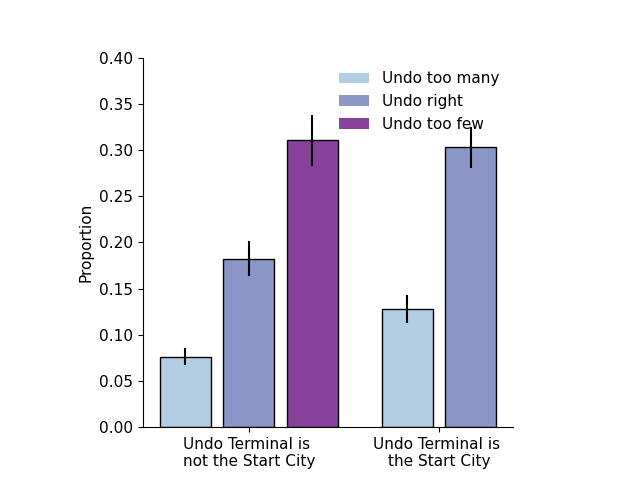

In [187]:
%matplotlib widget

fig, axs = plt.subplots(1, 1)
plt.bar(range(3), np.mean(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"],axis=0),
        color= ["#b3cde3", "#8c96c6", "#88419d"], 
        edgecolor = 'k', 
        yerr= np.std(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"],axis = 0)/np.sqrt(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="notstart"].shape[0]))
plt.bar([3.5,4.5], np.mean(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"],axis=0),
        edgecolor = 'k', 
        color= ["#b3cde3", "#8c96c6"],
        yerr= np.std(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"],axis = 0)/np.sqrt(accu_error_p.iloc[:,accu_error_p.columns.get_level_values(1)=="start"].shape[0])
               )
#plt.legend(color = ["red", "blue", "green"],
#           labels = ['Undo too many','Undo right','Undo too few'])
legend_elements = [Patch(facecolor='#b3cde3', label='Undo too many'),    
                   Patch(facecolor='#8c96c6', label='Undo right'),    
                   Patch(facecolor='#88419d', label='Undo too few')]
# create the legend
plt.legend(handles=legend_elements)


plt.xticks([1,4], ['Undo Terminal is \nnot the Start City','Undo Terminal is \nthe Start City'])
plt.ylabel('Proportion')
# 
axs.set_ylim([0,0.4])
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_completion type.png', dpi=300, bbox_inches='tight')

## what predicts the undo terminal

### sequential or single

<AxesSubplot:xlabel='terminal_beginning', ylabel='terminal_number'>

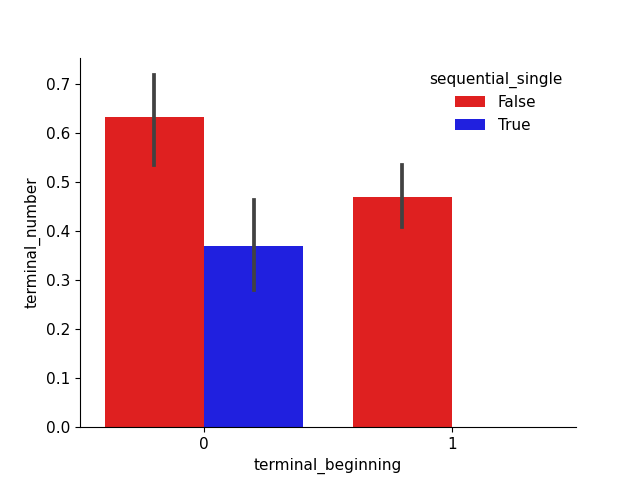

In [202]:
accu_error["terminal_number"] = (accu_error.terminal=="start").astype(int)

plot_df = accu_error.groupby(['sequential_single','terminal_beginning','subjects'])['terminal_number'].mean().reset_index()
# plot 
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.barplot(x='terminal_beginning', y='terminal_number', 
             data = plot_df,
             hue = 'sequential_single',
             palette = ['red','blue'])

### RT1

  rt1_bin  terminal_number
0       1               32
1       2               75
2       3               73
3       4               61
4       5               41


<AxesSubplot:xlabel='rt1_bin', ylabel='terminal_number'>

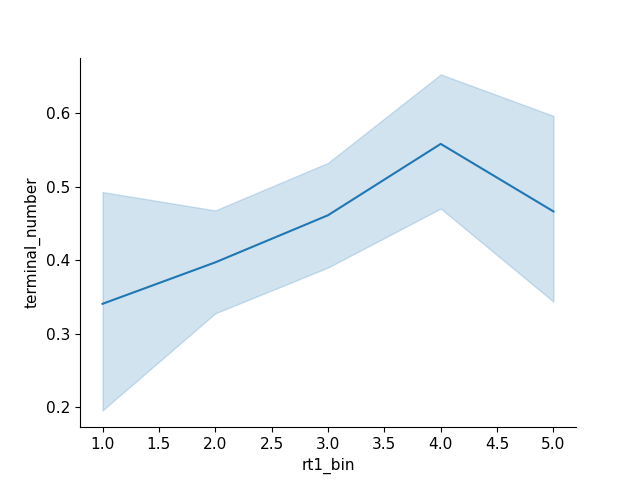

In [230]:
accu_error['RT1_log'] = np.log(1+accu_error.RT1)
temp1, cutoff = pd.cut(accu_error['RT1_log'], bins=[0,1,1.5,2,2.5,5], labels=range(1,6),retbins=True)
accu_error['rt1_bin'] = temp1

accu_error["terminal_number"] = (accu_error.terminal=="start").astype(int)

plot_df = accu_error.groupby(['rt1_bin','subjects'])['terminal_number'].mean().reset_index()
print(plot_df.groupby(['rt1_bin'])['terminal_number'].count().reset_index())
# plot 
%matplotlib widget
fig, axs = plt.subplots(1, 1)

# multiple line plot
sns.lineplot(x='rt1_bin', y='terminal_number', 
             data = plot_df)

### cumulative error magnitude

In [255]:
accu_error['undo_right'] = (accu_error.category==1)
accu_error['undo_too_many'] = (accu_error.category==0)
accu_error['undo_too_few'] = (accu_error.category==2)

In [ ]:
undo_right_sub = accu_error.groupby(['subjects','cum_error_beginning'])['undo_right'].mean().reset_index()
undo_right_sub.groupby(['cum_error_beginning'])['undo_right'].count()

cum_error_beginning
1    82
2    82
3    58
4    31
5     4
6     1
Name: undo_right, dtype: int64

In [249]:
accu_error

,subjects,puzzleID,terminal_beginning,cum_error_beginning,error_beginning,error_rate_beginning,category,sequential_single,terminal,terminal_number,...,final_error_rate,SeverityError1,numFullUndo,RTlater,RT_branching,RT1_log,rt1_bin,undo_right,undo_too_many,undo_too_few
0,0,28,1,3,0,0.500000,0,False,start,1,...,0.125000,0,2.0,2.486833,1.648,2.185264,4,False,True,False
1,1,15,1,3,1,0.500000,1,False,start,1,...,0.000000,2,1.0,3.400615,NaN,2.548898,5,True,False,False
2,1,18,1,2,0,0.250000,1,False,start,1,...,0.111111,1,1.0,3.405000,NaN,2.175547,4,True,False,False
3,1,30,0,1,0,0.166667,1,False,start,1,...,0.333333,1,1.0,6.553000,NaN,3.359055,5,True,False,False
4,1,38,0,2,1,0.666667,1,False,start,1,...,0.125000,1,1.0,5.806667,NaN,3.481855,5,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039,99,17,1,1,0,0.142857,0,False,notstart,0,...,0.142857,0,4.0,1.428958,NaN,1.208363,2,False,True,False
2040,99,24,0,1,0,0.333333,2,True,notstart,0,...,0.111111,1,1.0,1.183222,NaN,1.363026,2,False,False,True
2041,99,29,1,1,0,0.125000,0,False,notstart,0,...,0.000000,1,2.0,1.398842,NaN,1.672225,3,False,True,False
2042,99,31,1,1,0,0.111111,0,False,notstart,0,...,0.000000,0,1.0,1.540143,NaN,1.831621,3,False,True,False


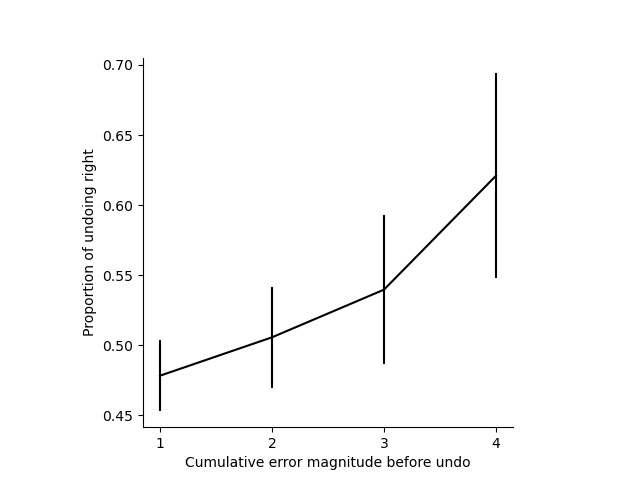

In [ ]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.lineplot(x='cum_error_beginning', y='undo_right',
                data = undo_right_sub[undo_right_sub.cum_error_beginning<=4],
                color = 'black', #'#8da0cb'
                err_style = "bars",
                errorbar = "se")

axs.set_xticks([1,2,3,4])
#axs.set_ylim(0,0.15)

axs.set(xlabel='Cumulative error magnitude before undo', ylabel='Proportion of undoing right')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_right_cumulative_error.png', dpi=300, bbox_inches='tight')

In [256]:
%%R -i accu_error,out_dir2
accu_error$subjects <- as.factor(accu_error[,"subjects"])

model_undo_right = lme4::glmer(undo_right ~  1 + cum_error_beginning + (1 |subjects) ,
                                  data = accu_error, family = binomial(link="logit"))

save(model_undo_right, accu_error, file=file.path(out_dir2, file=paste("model_undo_right_cumulative_error.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo_right)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: undo_right ~ 1 + cum_error_beginning + (1 | subjects)
   Data: accu_error

     AIC      BIC   logLik deviance df.resid 
  2766.4   2783.2  -1380.2   2760.4     2041 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6249 -0.9121 -0.5769  1.0031  2.0223 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.2796   0.5287  
Number of obs: 2044, groups:  subjects, 90

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.53693    0.12360  -4.344 1.40e-05 ***
cum_error_beginning  0.27524    0.06059   4.543 5.56e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
cm_rrr_bgnn -0.765


### error magnitude before undo

In [ ]:
undo_right_sub = accu_error.groupby(['subjects','error_beginning'])['undo_right'].mean().reset_index()
undo_right_sub.groupby(['error_beginning'])['undo_right'].count()

error_beginning
0    86
1    76
2    33
3    14
4     1
6     1
Name: undo_right, dtype: int64

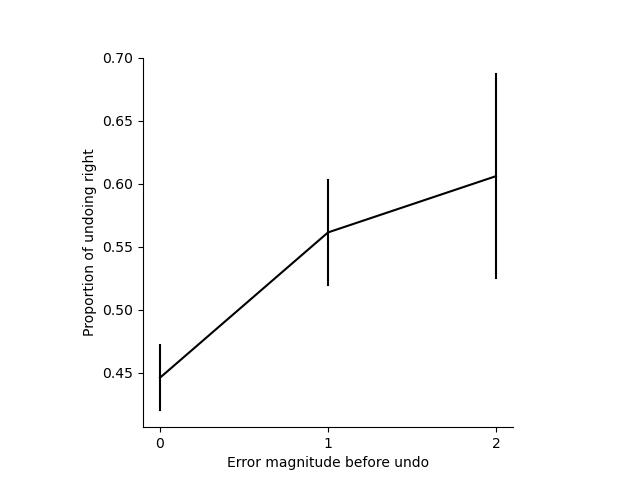

In [ ]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.lineplot(x='error_beginning', y='undo_right',
                data = undo_right_sub[undo_right_sub.error_beginning<=2],
                color = 'black', #'#8da0cb'
                err_style = "bars",
                errorbar = "se")

axs.set_xticks([0,1,2])
#axs.set_ylim(0,0.15)

axs.set(xlabel='Error magnitude before undo', ylabel='Proportion of undoing right')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_right_error.png', dpi=300, bbox_inches='tight')

In [257]:
%%R -i accu_error,out_dir2
accu_error$subjects <- as.factor(accu_error[,"subjects"])
accu_error$error_beginning <- scale(accu_error$error_beginning)
accu_error$cum_error_beginning <- scale(accu_error$cum_error_beginning)

model_undo_right = lme4::glmer(undo_right ~  1 + error_beginning + (1 |subjects) ,
                                  data = accu_error, 
                                  family = binomial(link="logit"))

save(model_undo_right, accu_error, file=file.path(out_dir2, file=paste("model_undo_right_error_and_cumulative.RData", sep="")))

# get the coefficients for the best fitting model
summary(model_undo_right)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: undo_right ~ 1 + error_beginning + (1 | subjects)
   Data: accu_error

     AIC      BIC   logLik deviance df.resid 
  2763.7   2780.6  -1378.8   2757.7     2041 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9653 -0.9051 -0.5924  1.0037  1.6881 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.272    0.5215  
Number of obs: 2044, groups:  subjects, 90

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -0.11554    0.07903  -1.462    0.144    
error_beginning  0.23512    0.04992   4.709 2.48e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
errr_bgnnng -0.014


### Error rate

In [ ]:
undo_right_sub = accu_error.groupby(['subjects','error_rate_beginning'])['undo_right'].mean().reset_index()
undo_right_sub.groupby(['error_rate_beginning'])['undo_right'].count()

error_rate_beginning
0.090909    28
0.100000    28
0.111111    66
0.125000    70
0.142857    60
0.166667    54
0.200000    24
0.222222    16
0.250000    69
0.285714    62
0.333333    48
0.375000     6
0.400000    29
0.428571    35
0.500000    57
0.571429     1
0.600000    20
0.666667    19
0.714286     1
0.750000     7
0.800000    14
0.833333     1
1.000000    22
1.250000     1
1.333333     7
1.500000     6
2.000000     1
3.000000     1
Name: undo_right, dtype: int64

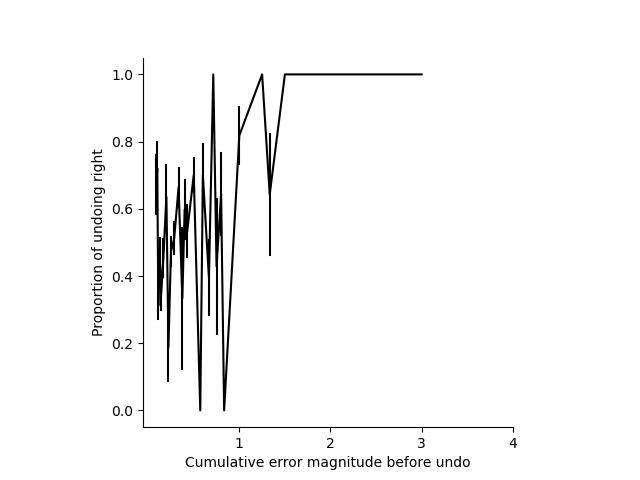

In [ ]:
%matplotlib widget
fig, axs = plt.subplots(1, 1)

sns.lineplot(x='error_rate_beginning', y='undo_right',
                data = undo_right_sub,
                color = 'black', #'#8da0cb'
                err_style = "bars",
                errorbar = "se")

axs.set_xticks([1,2,3,4])
#axs.set_ylim(0,0.15)

axs.set(xlabel='Cumulative error magnitude before undo', ylabel='Proportion of undoing right')
axs.set_aspect(1/axs.get_data_ratio())
plt.show()
fig.savefig(out_dir+'undo_right_cumulative_errorrate.png', dpi=300, bbox_inches='tight')

## Correlations

## Metric 1: proportions

In [ ]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
undo_right_prop = accu_error.groupby(['subjects'])['undo_right'].mean()

# only keep subjects who have both scores
score = score[score.index.isin(undo_right_prop.index)]

spearmanr(score, undo_right_prop)

SpearmanrResult(correlation=-0.13312064506005297, pvalue=0.21100181575591548)

In [ ]:
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
undo_few_prop = accu_error.groupby(['subjects'])['undo_too_few'].mean()

# only keep subjects who have both scores
score = score[score.index.isin(undo_few_prop.index)]

spearmanr(score, undo_few_prop)

SpearmanrResult(correlation=0.1470036625195117, pvalue=0.16677864009093307)

In [ ]:
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(undo_right_prop.index)]
spearmanr(balanced_accuracy, undo_right_prop)

SpearmanrResult(correlation=-0.033595457200651664, pvalue=0.7532566675233603)

In [ ]:
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(undo_few_prop.index)]
spearmanr(balanced_accuracy, undo_few_prop)

SpearmanrResult(correlation=-0.06698676011526265, pvalue=0.5304532980708084)

## Metric 2: Error rate change

In [ ]:
error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()
error_rate_change = error_df_sub['error_rate_end'] - error_df_sub['error_rate_beginning']
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
score = score[score.index.isin(error_rate_change.index)]
spearmanr(error_rate_change, score)

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_36892/3807902533.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()


SpearmanrResult(correlation=-0.03115437580352458, pvalue=0.7706722334841731)

In [ ]:
error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()
error_rate_change = error_df_sub['error_rate_end'] - error_df_sub['error_rate_beginning']
balanced_accuracy = (undo_error_avg + TNR)/2
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(error_rate_change.index)]
spearmanr(error_rate_change, balanced_accuracy)

/var/folders/1f/jm7zf5792lvd000qt0vb8jmr5t6hzx/T/ipykernel_36892/2976432119.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  error_df_sub = mas_gain_df.groupby(['subjects'])['error_rate_beginning','error_rate_end'].mean().reset_index()


SpearmanrResult(correlation=-0.0444307239747956, pvalue=0.6775415110542389)

## Metric 3: MAS gain

In [ ]:
mas_gain = mas_gain_df.groupby(['subjects'])['mas_gain'].mean()
balanced_accuracy = (undo_error_avg + TNR)/2
balanced_accuracy = balanced_accuracy[balanced_accuracy.index.isin(mas_gain.index)]
spearmanr(mas_gain, balanced_accuracy)

SpearmanrResult(correlation=-0.10919093542725634, pvalue=0.30561654498857593)

In [ ]:
mas_gain = mas_gain_df.groupby(['subjects'])['mas_gain'].mean()
score = puzzleID_order_data[puzzleID_order_data['condition']==0].groupby(['subjects'])['sumSeverityErrors'].mean()
score = score[score.index.isin(mas_gain.index)]
spearmanr(mas_gain, score)

SpearmanrResult(correlation=0.25321224856022057, pvalue=0.016040797773219848)